## Libraries

In [4]:
from datasets import load_dataset

import pandas as pd
import numpy as np
import sklearn
from collections import deque
from sortedcontainers import SortedList

import networkx as nx
from networkx.algorithms import bipartite

from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates 
import seaborn as sns
import plotly.express as px

In [5]:
# https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

## Initial Dataset Overview

In [110]:
# Check data types 
print("\nDataset information:")
print(df.info())

# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# no duplicated rows
print("\nDuplicated Values:")
print("Duplicated values found" if any(df.duplicated()) else "No duplicated values found")
print()

# Check overall statistics
print(df.describe())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB
None

Missing Values:
No missing values found

Duplicated Values:
No duplicated values found

             cc_num           zip      city_pop      acct_num     unix_time  \
count  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  

## Data Preprocessing

In [111]:
df1 = df.copy()

In [112]:
# Convert date and time to appropriate data types
df1[['trans_date','dob']] = df1[['trans_date','dob']].apply(pd.to_datetime)
df1['trans_time'] = pd.to_datetime(df1['trans_time'], format='%H:%M:%S')

# Extract transaction time features
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df1['hour'] = df1['trans_time'].dt.hour
df1['day_of_week'] = pd.Categorical(df1['trans_date'].dt.day_name(), categories=week_order, ordered=True)
df1['month'] = df1['trans_date'].dt.to_period('M').dt.to_timestamp()
df1["trans_quarter"] = pd.PeriodIndex(df1['month'], freq='Q')
df1['year'] = df1['trans_date'].dt.year

# Calculate age at the time of the transaction
def calc_age(data):
    est = data['year'] - data['dob'].year
    if (data['trans_date'].month < data['dob'].month) or ((data['trans_date'].month == data['dob'].month) and (data['trans_date'].day < data['dob'].day)):
        return est - 1
    else:
        return est
    
df1['age'] = df1.apply(lambda x: calc_age(x), axis = 1)
df1['age_group'] = pd.cut(df1['age'], bins=range(0, 101, 10), right=False, 
                             labels=[f"{i}-{i+10}" for i in range(0, 100, 10)]) 

# Merge `city` and `state` columns
df1['city_state'] = df1['city'] + ', ' + df1['state']

# Clean `ssn` feature
df1['ssn']=df1['ssn'].str.replace('-','')
df1['ssn']=df1['ssn'].astype(int)

# Clean `merchant` feature
df1['merchant']=df1['merchant'].str.replace('fraud_','',regex=False)

In [113]:
# Dataset after preprocessing
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 28 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ssn            int64         
 1   cc_num         int64         
 2   first          object        
 3   last           object        
 4   gender         object        
 5   city           object        
 6   state          object        
 7   zip            int64         
 8   city_pop       int64         
 9   job            object        
 10  dob            datetime64[ns]
 11  acct_num       int64         
 12  trans_num      object        
 13  trans_date     datetime64[ns]
 14  trans_time     datetime64[ns]
 15  unix_time      int64         
 16  category       object        
 17  amt            float64       
 18  is_fraud       int64         
 19  merchant       object        
 20  hour           int32         
 21  day_of_week    category      
 22  month          datetime64[ns]
 23  trans_q

### Helper functions

In [114]:
# Helper functions
def fraud_filter(cols):
    return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def fraud_summary(df, col):
    print(f'Average fraud per {col}: {np.mean(df["fraud_count"])}')
    print(f'Median fraud per {col}: {np.median(df["fraud_count"])}')
    print(f'Standard deviation fraud per {col}: {np.std(df["fraud_count"])}')


## Data Exploration

In [115]:
# Check unique values in categorical columns
categorical = []

print('Unique values count')
for f in df1.columns:
    feature = df1[f]

    print(f'{f} unique values: {feature.nunique()}')
    if feature.dtype == float or feature.dtype == '<M8[ns]':
        print(' Not categorical')
        continue
    # If the number of unique features is less than half, more likely to be categorical
    if feature.nunique() < len(df1)/2:
        categorical.append(f)
        if feature.nunique() < 10:
            print(f'    Unique values: {feature.unique()}')
        continue
    print(' Not categorical')

Unique values count
ssn unique values: 997
cc_num unique values: 997
first unique values: 368
last unique values: 496
gender unique values: 2
    Unique values: ['F' 'M']
city unique values: 741
state unique values: 51
zip unique values: 942
city_pop unique values: 787
job unique values: 420
dob unique values: 978
 Not categorical
acct_num unique values: 997
trans_num unique values: 2646694
 Not categorical
trans_date unique values: 1095
 Not categorical
trans_time unique values: 86400
 Not categorical
unix_time unique values: 2573660
 Not categorical
category unique values: 14
amt unique values: 70272
 Not categorical
is_fraud unique values: 2
    Unique values: [1 0]
merchant unique values: 648
hour unique values: 24
day_of_week unique values: 7
    Unique values: ['Saturday', 'Sunday', 'Thursday', 'Wednesday', 'Friday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']
month unique values: 36
 Not catego

In [116]:
# Yearly transactions count: output looks evenly split
df1['year'].value_counts()

year
2023    884851
2022    882285
2021    879558
Name: count, dtype: int64

In [117]:
# Check if any `ssn` is linked to multiple credit card numbers
creditcard_count = df1.groupby('ssn')['cc_num'].apply(set).reset_index()
print(creditcard_count[creditcard_count['cc_num'].apply(lambda x: len(x)>1)]) # result: 1 ssn linked to only 1 cc_num

Empty DataFrame
Columns: [ssn, cc_num]
Index: []


In [118]:
# remove names (since users can be identified by `ssn`), cc_num (each `ssn` is uniquely identified with ssn)
df1.drop(columns=['first','last','cc_num'])

,ssn,gender,city,state,zip,city_pop,job,dob,acct_num,trans_num,...,is_fraud,merchant,hour,day_of_week,month,trans_quarter,year,age,age_group,city_state
0,367859826,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,c036244703adb9d5392f4027d9d4b38d,...,1,Kovacek,2,Saturday,2021-07-01,2021Q3,2021,34,30-40,"Chandler, OK"
1,367859826,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,42f000b0b3b0ef534e5b8ef9ec1db13a,...,1,Bradtke,22,Sunday,2021-08-01,2021Q3,2021,34,30-40,"Chandler, OK"
2,367859826,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,543037b1baf088961e58d00b705f4bcc,...,1,Kozey-Kuhlman,23,Sunday,2021-08-01,2021Q3,2021,34,30-40,"Chandler, OK"
3,367859826,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,00a4e08643edebf9277c2967676f6a26,...,1,Hills,22,Sunday,2021-08-01,2021Q3,2021,34,30-40,"Chandler, OK"
4,367859826,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,492c4412815306718f686fc5b459a285,...,0,Kemmer-Buckridge,2,Thursday,2021-12-01,2021Q4,2021,34,30-40,"Chandler, OK"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646689,751289829,F,Pleasant Garden,NC,27313,6962,Museum/gallery curator,1969-09-14,834942757900,b2d8cfd9502a982b910edeea05baebe8,...,0,Cartwright PLC,22,Friday,2023-06-01,2023Q2,2023,53,50-60,"Pleasant Garden, NC"
2646690,751289829,F,Pleasant Garden,NC,27313,6962,Museum/gallery curator,1969-09-14,834942757900,b688d8f1f21483947654a25891dd80fe,...,0,Waelchi Inc,12,Thursday,2023-07-01,2023Q3,2023,53,50-60,"Pleasant Garden, NC"
2646691,751289829,F,Pleasant Garden,NC,27313,6962,Museum/gallery curator,1969-09-14,834942757900,f12b8b2933bb5280f4e8f41dd8d91295,...,0,Emmerich-Rau,20,Friday,2023-10-01,2023Q4,2023,54,50-60,"Pleasant Garden, NC"
2646692,751289829,F,Pleasant Garden,NC,27313,6962,Museum/gallery curator,1969-09-14,834942757900,b243e1332abfcd5735cb0631e2fcc168,...,0,Renner Ltd,19,Friday,2023-05-01,2023Q2,2023,53,50-60,"Pleasant Garden, NC"


## Fraudulent Label Analysis

#### Analysis Overview

In [119]:
# Summary statistics for fraudulent transactions
fraud_summarised = df1[df1['is_fraud'] == 1].describe()
print(fraud_summarised)

                ssn        cc_num           zip      city_pop  \
count  9.422000e+03  9.422000e+03   9422.000000  9.422000e+03   
mean   4.458670e+08  3.909210e+17  51318.872745  2.954356e+05   
min    1.280753e+06  6.040027e+10   1040.000000  1.410000e+02   
25%    2.064273e+08  3.897245e+13  27806.000000  1.718400e+04   
50%    4.653727e+08  3.506538e+15  48433.000000  5.922300e+04   
75%    6.642008e+08  4.506150e+15  77450.000000  2.398790e+05   
max    8.975991e+08  4.997335e+18  99701.000000  2.906700e+06   
std    2.595013e+08  1.265245e+18  29771.729243  5.808730e+05   

                                 dob      acct_num  \
count                           9422  9.422000e+03   
mean   1975-07-04 17:59:55.414986208  4.939769e+11   
min              1928-06-07 00:00:00  8.077997e+08   
25%              1961-09-07 00:00:00  2.443508e+11   
50%              1976-02-27 00:00:00  4.873495e+11   
75%              1992-04-08 00:00:00  7.486302e+11   
max              2008-10-14 00:00:00

**High imbalance in fraud and non-fraud counts**

Methods like SMOTE are needed to address imbalance

Fraud Distribution:
is_fraud
0    2637272
1       9422
Name: count, dtype: int64
Fraud Rate: 0.0036 (0.36%)


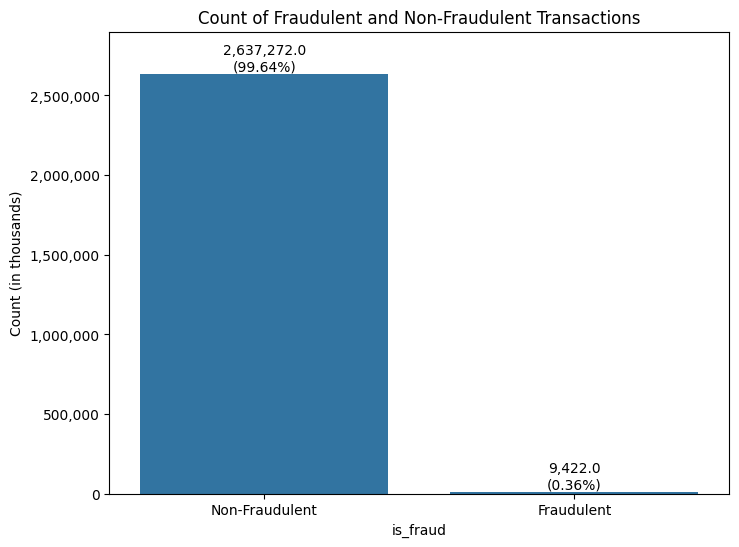

In [170]:
# Fraud distribution
print("Fraud Distribution:")
fraud_counts = df1['is_fraud'].value_counts()
print(fraud_counts)

# Fraud rate
fraud_rate = df1['is_fraud'].mean()
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate * 100:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='is_fraud')

# Customize the plot
ax.set_ylabel('Count (in thousands)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Count of Fraudulent and Non-Fraudulent Transactions')
ax.set_xticks([0, 1])  # Set x-ticks
ax.set_xticklabels(['Non-Fraudulent', 'Fraudulent'])  # Label x-axis

# Extend y-axis limits slightly for readability
plt.ylim(0, max(fraud_counts) * 1.1)
# Add count and percentage on the bars
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        height + 1000,  # Y position (slightly above the bar)
        f'{height:,}\n({percentage:.2f}%)',  # Text (count and percentage)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

plt.show()

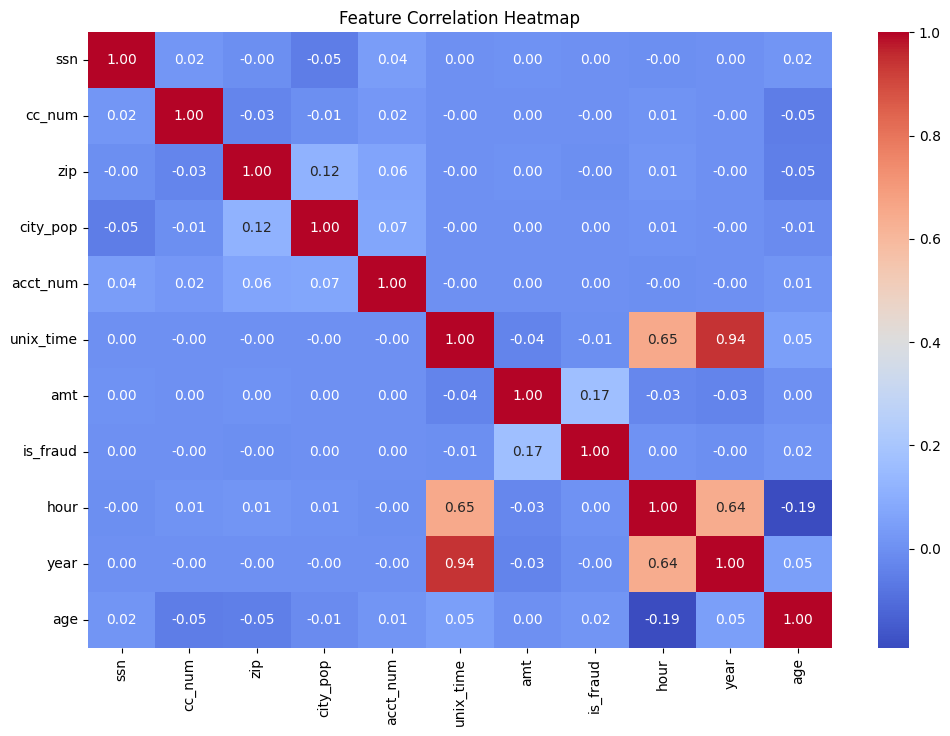

In [121]:
# Correlation heat map
df_numeric = df1.select_dtypes(include=['number'])

# Create the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Fraudulent transactions by hour

In [122]:
# Get fraudulent transactions by hour
hour_fraud = df1.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0).reset_index(names=['hour', 0, 1])
hour_fraud.columns.name = None

#  Display the count of fraud by hour
print("Fraud Count by Hour:")
hour_fraud

Fraud Count by Hour:


,hour,0,1
0,0,83693,852
1,1,83202,855
2,2,83214,845
3,3,83660,872
4,4,83786,67
5,5,84056,59
6,6,83781,68
7,7,83892,62
8,8,83972,68
9,9,83696,59


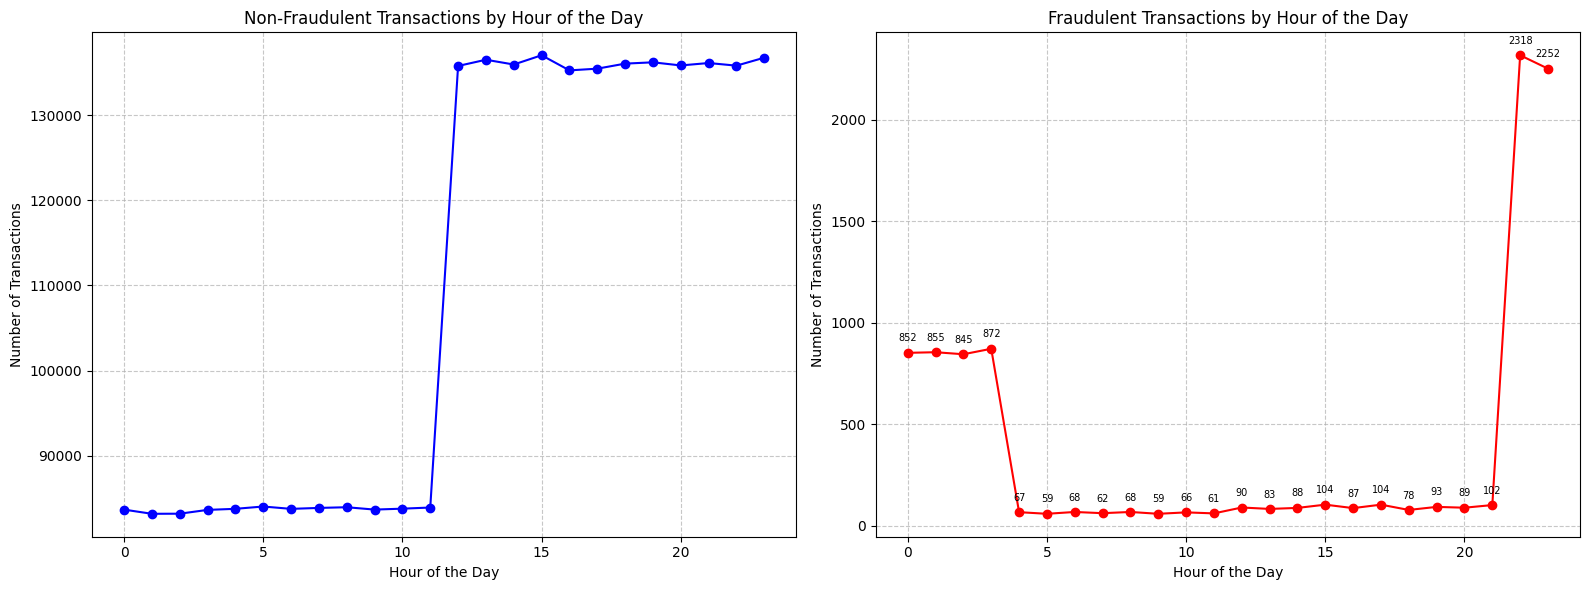

In [123]:
# Create subplots for hour analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by hour
axes[0].plot(hour_fraud.index, hour_fraud[0], color='blue', marker='o')
axes[0].set_title('Non-Fraudulent Transactions by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Transactions')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Add data point values: Too cramped and not as useful
'''for x, y in zip(hour_fraud['hour'], hour_fraud[0]):
    axes[0].text(x, y+max(hour_fraud[0])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=8)'''
    
# Plot Fraudulent Transactions by hour
axes[1].plot(hour_fraud.index, hour_fraud[1], color='red', marker='o')
axes[1].set_title('Fraudulent Transactions by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Transactions')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Add data point values
for x, y in zip(hour_fraud['hour'], hour_fraud[1]):
    axes[1].text(x, y+max(hour_fraud[1])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=7)
    

plt.tight_layout()
plt.show()

In [124]:
# Group by unix_time and count transactions
time_grouped = df1.groupby('unix_time').agg(
    num_transactions=('trans_num', 'size'),
    num_unique_cards=('cc_num', 'nunique'),
    num_unique_merchants=('merchant', 'nunique'),
    num_fraud=('is_fraud', 'sum'),
).reset_index()

# Filter for times with multiple transactions
suspicious_times = time_grouped[time_grouped['num_transactions'] > 1].sort_values(by='num_transactions', ascending=False)

# Display the top 10 suspicious times
print("Top 10 Suspicious unix_time with multiple transactions:")
print(suspicious_times.head(10))

# results show that despite sharing unix_time, most of these transactions seem to be all unique and independent,
# hence unlikely to be coordinated fraud. Could be due to peak shopping times or other reasons.  

Top 10 Suspicious unix_time with multiple transactions:
          unix_time  num_transactions  num_unique_cards  num_unique_merchants  \
829445   1640427909                 5                 5                     5   
2299353  1695553714                 5                 5                     5   
2556003  1703772009                 5                 5                     5   
376979   1625265945                 4                 4                     4   
471629   1628374273                 4                 4                     4   
178987   1617998927                 4                 4                     4   
1215969  1656161807                 4                 4                     4   
558446   1631405689                 4                 4                     4   
343805   1624137368                 4                 4                     4   
491215   1628990684                 4                 4                     4   

         num_fraud  
829445           0  
2299353   

### Fraudulent transactions by day of the week

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\314172443.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



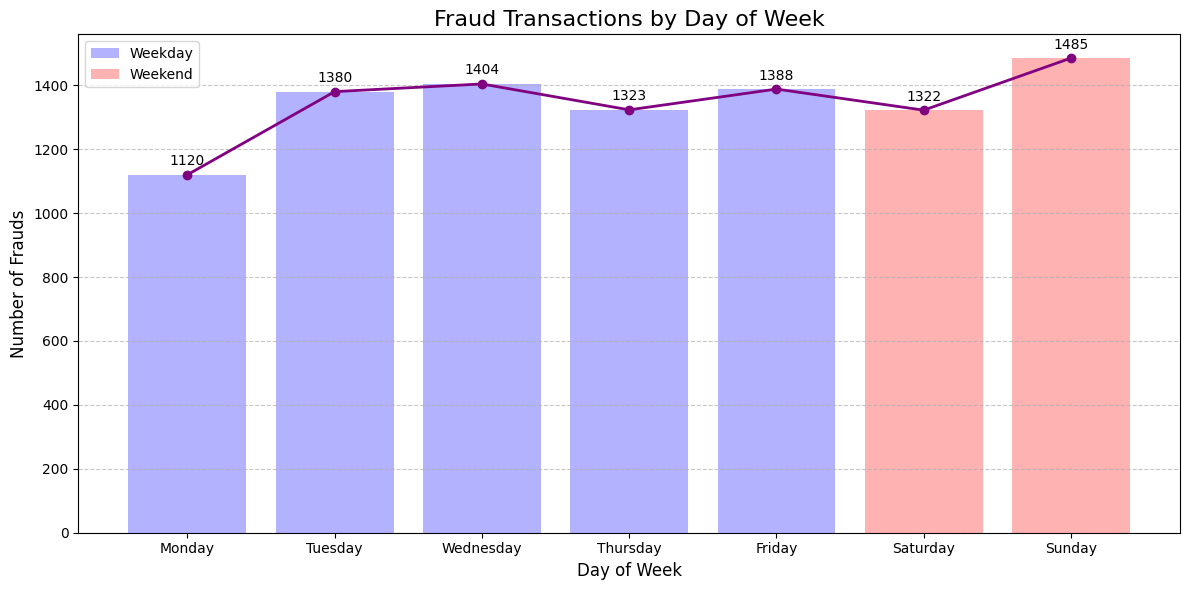

Total Weekday Frauds: 6615
Total Weekend Frauds: 2807
Weekday Average (per day): 1323.00
Weekend Average (per day): 1403.50


In [125]:
# Filter for fraud by day of week
fraud_daily_df = fraud_filter('day_of_week')
fraud_daily_df['Is_Weekend'] = [0, 0, 0, 0, 0, 1, 1] # 0 for weekday, 1 for weekend

# Plot fraud count by day of week
plt.figure(figsize=(12, 6))

# Set different colors for weekdays and weekends
colors = ['blue' if is_weekend == 0 else 'red' for is_weekend in fraud_daily_df['Is_Weekend']]

plt.plot(fraud_daily_df['day_of_week'], fraud_daily_df['fraud_count'], 
         marker='o', linestyle='-', color='purple', linewidth=2)

# Add bars with different colors for weekday/weekend
plt.bar(fraud_daily_df['day_of_week'], fraud_daily_df['fraud_count'], 
        alpha=0.3, color=colors)

# Add title and labels
plt.title("Fraud Transactions by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add legend
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Weekday'),
    Patch(facecolor='red', alpha=0.3, label='Weekend')
]
plt.legend(handles=legend_elements)

# Add value labels above each bar
for i, count in enumerate(fraud_daily_df['fraud_count']):
    plt.text(i, count + max(fraud_daily_df['fraud_count'])*0.02, f'{int(count)}', 
             ha='center', fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary of weekday vs weekend
weekday_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 0]['fraud_count'].sum()
weekend_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 1]['fraud_count'].sum()

print(f"Total Weekday Frauds: {int(weekday_fraud)}")
print(f"Total Weekend Frauds: {int(weekend_fraud)}")
print(f"Weekday Average (per day): {weekday_fraud/5:.2f}")
print(f"Weekend Average (per day): {weekend_fraud/2:.2f}")

### Fraudulent transactions by date

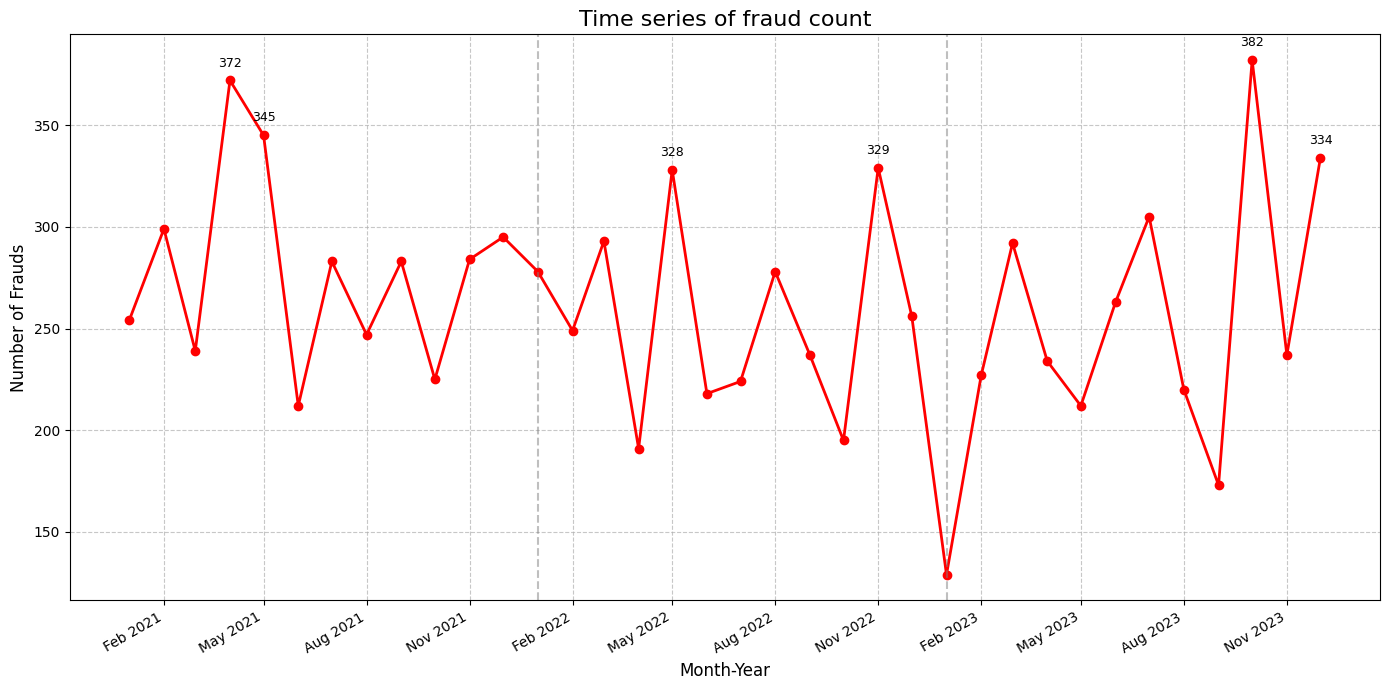

Total number of frauds: 9422
Month with most frauds: Oct 2023 (382 frauds)
Month with least frauds: Jan 2023 (129 frauds)


In [126]:
# Overview of fraud counts by month
fraud_count_df = df1[["month", "is_fraud"]].groupby(by = "month", as_index = False).sum().rename(columns={'month':'Date', 'is_fraud':'Fraud_Count'}).sort_values('Date')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(fraud_count_df['Date'], fraud_count_df['Fraud_Count'], 
         marker='o', linestyle='-', color='red', linewidth=2)

# Format x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add title and labels
plt.title("Time series of fraud count", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight year transitions with vertical lines
years = fraud_count_df['Date'].dt.year.unique()
for year in years[1:]:  # Skip the first year
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color='gray', linestyle='--', alpha=0.5)

# Add data annotations for peak points
peak_threshold = fraud_count_df['Fraud_Count'].max() * 0.8
peaks = fraud_count_df[fraud_count_df['Fraud_Count'] >= peak_threshold]
for i, row in peaks.iterrows():
    plt.annotate(f"{int(row['Fraud_Count'])}", 
                 (row['Date'], row['Fraud_Count']),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics using existing data
print(f"Total number of frauds: {fraud_count_df['Fraud_Count'].sum()}")
print(f"Month with most frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmax(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].max())} frauds)")
print(f"Month with least frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmin(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].min())} frauds)")


<Figure size 800x600 with 0 Axes>

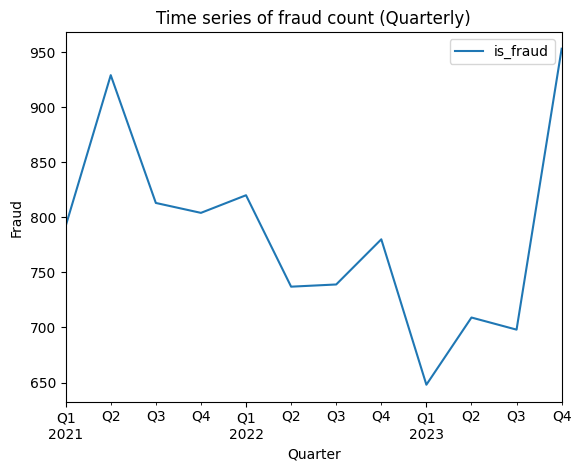

In [127]:
# Fraud counts on quarterly basis
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").sum()

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Time series of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\723376522.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



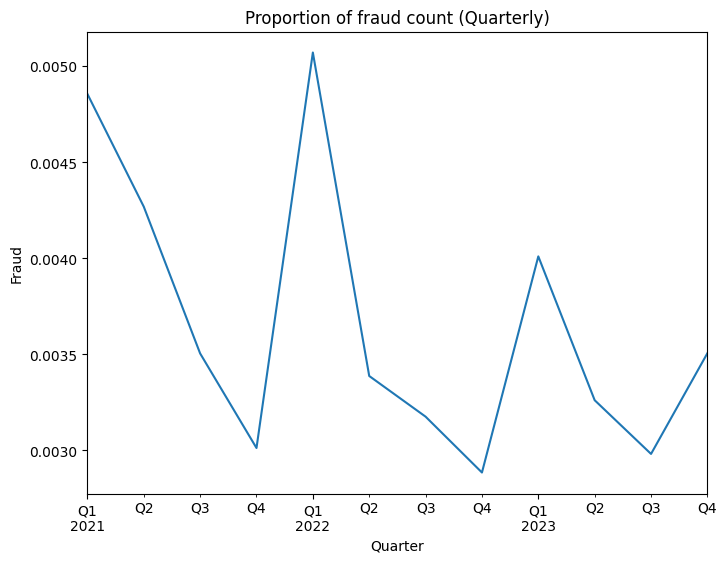

In [128]:
# Proportion of fraud (quarterly)
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Proportion of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

**Unlikely that fraud is committed by duplicate transactions**

While there are non-negligible numbers of fraudulent transactions with duplicate time, there are relatively few cases associated with any customer or merchant.

In [129]:
# Check if there is fraud related to transaction time
unix_count = df1.groupby('unix_time')['unix_time'].count().reset_index(name='count').sort_values('count', ascending=False)
unix_count = unix_count[unix_count['count'] > 1]['unix_time']

duplicated_unix_time = df1[df1['unix_time'].isin(unix_count)].sort_values('unix_time')
duplicated_unix_time

,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,...,is_fraud,merchant,hour,day_of_week,month,trans_quarter,year,age,age_group,city_state
1058234,804928268,503871487271,Tina,Olson,F,Avon,CT,6001,18385,Music therapist,...,0,Cummings LLC,0,Friday,2021-01-01,2021Q1,2021,32,30-40,"Avon, CT"
2576115,24730528,4599996636186379,Ashley,Hudson,F,Dallas,TX,75252,1263321,Embryologist,...,0,Bins-Rice,0,Friday,2021-01-01,2021Q1,2021,20,20-30,"Dallas, TX"
984222,158908788,5573585730652407,John,Kim,M,Gibsonia,PA,15044,27049,Designer,...,0,Raynor,0,Friday,2021-01-01,2021Q1,2021,20,20-30,"Gibsonia, PA"
389317,568920313,213164931214636,Leslie,Evans,F,Wickes,AR,71973,1424,Engineer,...,0,Christiansen,0,Friday,2021-01-01,2021Q1,2021,54,50-60,"Wickes, AR"
86591,813386608,30391900889913,Barbara,Wilson,F,Marietta,GA,30062,302309,Engineer,...,0,Cummings LLC,0,Friday,2021-01-01,2021Q1,2021,35,30-40,"Marietta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268502,310243661,373711222990773,Jacob,Hale,M,Fort Worth,TX,76103,813980,Health promotion specialist,...,0,Hodkiewicz,23,Sunday,2023-12-01,2023Q4,2023,49,40-50,"Fort Worth, TX"
414092,69452671,4029295014372,Destiny,Parrish,F,Massapequa,NY,11758,53804,Therapist,...,0,Fritsch LLC,23,Sunday,2023-12-01,2023Q4,2023,17,10-20,"Massapequa, NY"
684163,869591502,4900532931839331,Gary,Hernandez,M,Dallas,TX,75252,1263321,Agricultural engineer,...,0,Kovacek Ltd,23,Sunday,2023-12-01,2023Q4,2023,35,30-40,"Dallas, TX"
1382692,206427252,4233222801944258926,Mitchell,Ortega,M,Cleveland,OH,44126,769341,Artist,...,0,Corwin-Romaguera,23,Sunday,2023-12-01,2023Q4,2023,23,20-30,"Cleveland, OH"


In [130]:
# Identify merchants with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['merchant'])['merchant'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,merchant,count
150,Reichert,8
156,Romaguera,5
140,O'Keefe-Hudson,4
141,Pacocha-O'Reilly,4
21,Boyer PLC,4
45,Fisher-Schowalter,4
31,Cormier LLC,3
51,Gerlach Inc,3
89,Jaskolski-Vandervort,3
85,Huel-Langworth,3


In [131]:
# Identify ssn with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['ssn'])['ssn'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,ssn,count
213,805105003,4
128,486855972,3
169,645243054,3
234,883641316,3
231,872212853,3
126,477507101,3
104,404227265,3
26,86372495,3
2,11788315,2
59,255195413,2


**Fraudulent transactions tend to happen on the same day**

An analysis of customers' daily fraud rates (proportion of transactions that are fraud each day) reveals that for a given day, either none of a customer's transactions are fraudulent or all of their transactions are fraudulent. This means that fraudulent transactions tend to be conducted on the same day, and usually 3-5 transactions are made on these days,

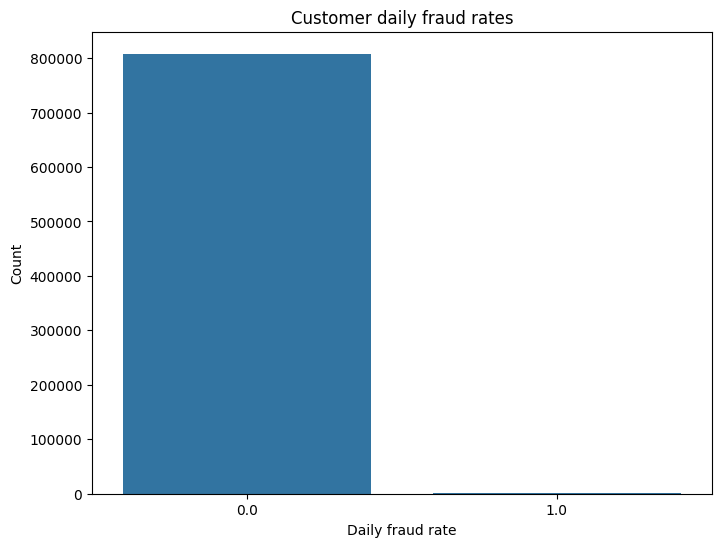

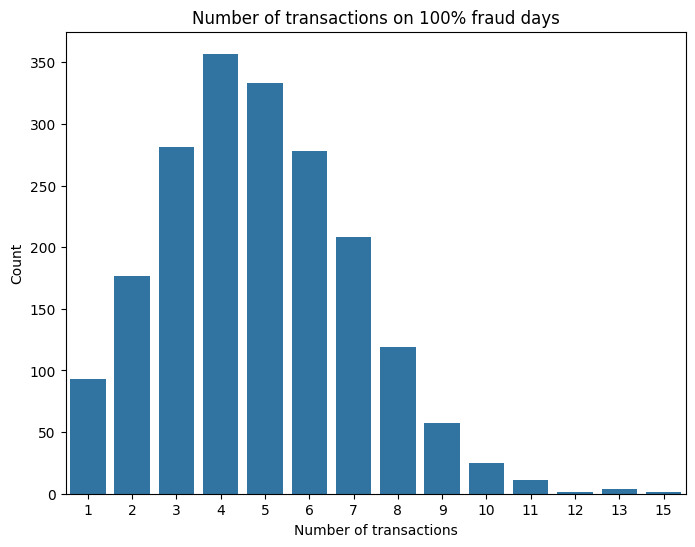

In [132]:
# Calculate customer daily fraud rate
customer_date_fraud = df1.groupby(['ssn', 'trans_date'])['is_fraud'].agg(['mean', 'count']).reset_index()
# Create count of daily fraud rates
customer_date_fraud_stats = customer_date_fraud['mean'].value_counts().reset_index(name = 'count')

# Plot bargraph
plt.figure(figsize = (8,6))
sns.barplot(data = customer_date_fraud_stats, x = 'mean', y = 'count')
plt.title('Customer daily fraud rates')
plt.xlabel('Daily fraud rate')
plt.ylabel('Count')
plt.show()

# Filter out 100% fraud days and count number of transactions
customer_date_fraud_num = customer_date_fraud.loc[customer_date_fraud['mean'] != 0, 'count'].value_counts().reset_index(name = 'num_trans')

# Plot bargraph
plt.figure(figsize = (8,6))
sns.barplot(data = customer_date_fraud_num, x = 'count', y = 'num_trans')
plt.title('Number of transactions on 100% fraud days')
plt.xlabel('Number of transactions')
plt.ylabel('Count')
plt.show()


**Fraud attacks typically only last 1-2 days and each customer is only affected once.**

In [133]:
# Filter for fraudulent transactions only
fraud_df = df1.loc[df1['is_fraud'] == 1]

# Find unique dates where each person had a fraudulent transaction
fraud_dates = fraud_df[['ssn', 'trans_date']].drop_duplicates().sort_values(['ssn', 'trans_date'])
# Find interval between successive fraud attacks
fraud_dates['prev_fraud'] = fraud_dates.groupby('ssn').shift(1)['trans_date']
fraud_dates['interval'] = (fraud_dates['trans_date'] - fraud_dates['prev_fraud']).dt.days

# Filter for fraud attacks that lasted more than 1 day
fraud_multiday = fraud_dates.dropna()
# Rename columns to reflect start and end date of attack
fraud_multiday = fraud_multiday.rename({'trans_date':'end_date', 
                      'prev_fraud':'start_date'}, axis = 1)

# Filter for fraud attacks that lasted only 1 day
fraud_1_day = fraud_dates.loc[fraud_dates['prev_fraud'].isna()]
# Add 'end_date' column that holds same value as 'trans_date
fraud_1_day['end_date'] = fraud_1_day['trans_date']
# Add 'interval' column 
fraud_1_day['interval'] = (fraud_1_day['end_date'] - fraud_1_day['trans_date']).dt.days
fraud_1_day = fraud_1_day.rename({'trans_date':'start_date'}, axis = 1)
fraud_1_day = fraud_1_day.drop(['prev_fraud'], axis = 1)

# Combine both dfs into 1
fraud_periods = pd.concat([fraud_multiday, fraud_1_day])    
fraud_periods = fraud_periods[['ssn', 'start_date', 'end_date', 'interval']]
fraud_periods = fraud_periods.sort_values(['end_date'], ascending = False).groupby(['ssn', 'start_date']).first()
print('All customers are only attacked once')
print(fraud_periods.groupby('ssn').size().reset_index(name = 'total_attacks')['total_attacks'].value_counts().reset_index(name = 'count'))

# Find actual period of fraud attack by adding 1 to interval column
fraud_periods['fraud_period'] = fraud_periods['interval'] + 1
print('\nEach fraud attack lasts only 1 or 2 days')
print(fraud_periods['fraud_period'].value_counts().reset_index(name = 'count'))
# fraud_periods = pd.melt(fraud_periods, id_vars = ['ssn', 'fraud_period'], value_vars = ['start_date', 'end_date'], value_name = 'trans_date')

All customers are only attacked once
   total_attacks  count
0              1    985

Each fraud attack lasts only 1 or 2 days
   fraud_period  count
0           2.0    960
1           1.0     25


C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\4022459378.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\4022459378.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ### Warm up and cool down periods (customers)

In [134]:
# Graph of warm up and cool down periods. Warm up period refer to no. of days between first normal transaction and first fradulent transactions.
# Cool down refers to no. of days between their very last fruadulent transaction and overall last transaction.
def calculate_periods(df):
    first_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    first_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    # Merge the DataFrames
    periods = pd.DataFrame(index=first_fraud.index)
    periods['first_trans_date'] = first_trans['trans_date']
    periods['last_trans_date'] = last_trans['trans_date']
    periods['first_fraud_date'] = first_fraud['trans_date']
    periods['last_fraud_date'] = last_fraud['trans_date']
    
    # Calculate periods in days
    periods['warmup_days'] = (periods['first_fraud_date'] - periods['first_trans_date']).dt.days
    periods['cooldown_days'] = (periods['last_trans_date'] - periods['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods['warmup_period_grp'] = periods['warmup_days'].apply(categorize_period)
    periods['cooldown_period_grp'] = periods['cooldown_days'].apply(categorize_period)
    
    return periods

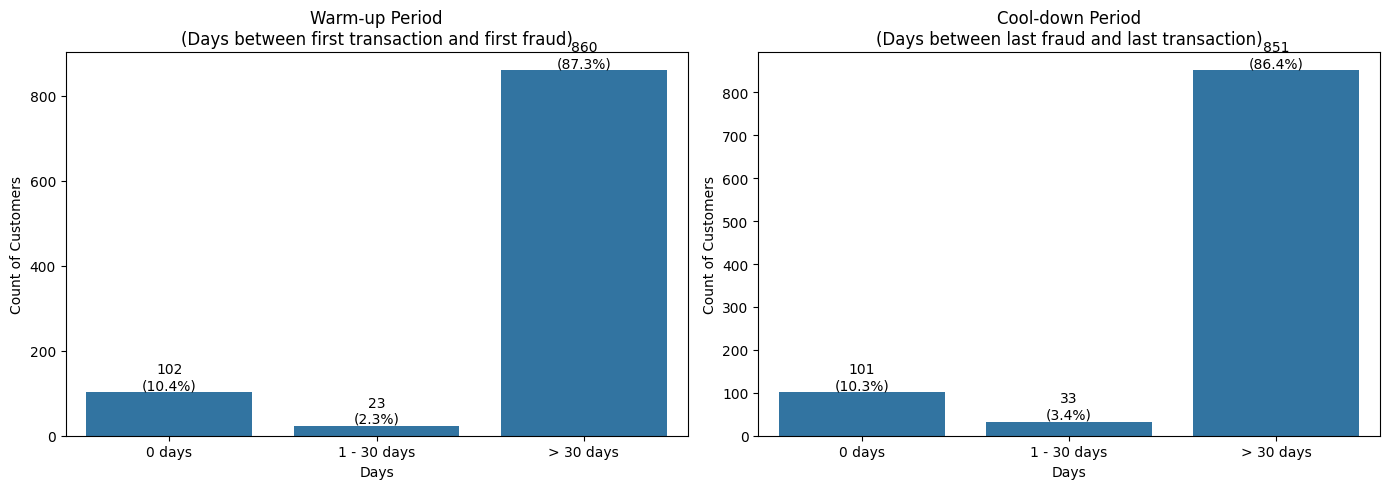

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days    102
1       1 - 30 days     23
2         > 30 days    860

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days    101
1         1 - 30 days     33
2           > 30 days    851

Percentage of customers whose first transaction was fraudulent:
10.4% (102 customers)

Percentage of customers whose last transaction was fraudulent:
10.3% (101 customers)


In [135]:
# Calculate periods
fraud_customer_periods = calculate_periods(df1)

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts = fraud_customer_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_customers = warmup_counts['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts = fraud_customer_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_customers = cooldown_counts['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts)

# Additional insights
print("\nPercentage of customers whose first transaction was fraudulent:")
first_fraud_pct = (fraud_customer_periods['warmup_days'] == 0).mean() * 100
print(f"{first_fraud_pct:.1f}% ({(fraud_customer_periods['warmup_days'] == 0).sum()} customers)")

print("\nPercentage of customers whose last transaction was fraudulent:")
last_fraud_pct = (fraud_customer_periods['cooldown_days'] == 0).mean() * 100
print(f"{last_fraud_pct:.1f}% ({(fraud_customer_periods['cooldown_days'] == 0).sum()} customers)")

 ### Warm up and cool down periods (merchants)

In [136]:
# Graph of warm up and cool down periods for merchants
def calculate_periods_merchants(df):
    first_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    first_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    # Merge the DataFrames
    periods_merchant = pd.DataFrame(index=first_fraud_merchant.index)
    periods_merchant['first_trans_date'] = first_trans_merchant['trans_date']
    periods_merchant['last_trans_date'] = last_trans_merchant['trans_date']
    periods_merchant['first_fraud_date'] = first_fraud_merchant['trans_date']
    periods_merchant['last_fraud_date'] = last_fraud_merchant['trans_date']
    
    # Calculate periods in days
    periods_merchant['warmup_days'] = (periods_merchant['first_fraud_date'] - periods_merchant['first_trans_date']).dt.days
    periods_merchant['cooldown_days'] = (periods_merchant['last_trans_date'] - periods_merchant['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods_merchant['warmup_period_grp'] = periods_merchant['warmup_days'].apply(categorize_period)
    periods_merchant['cooldown_period_grp'] = periods_merchant['cooldown_days'].apply(categorize_period)
    
    return periods_merchant

# Calculate periods
fraud_merchant_periods = calculate_periods_merchants(df1)

There are 648 unique merchants. 641 of them have been involved in fraud.


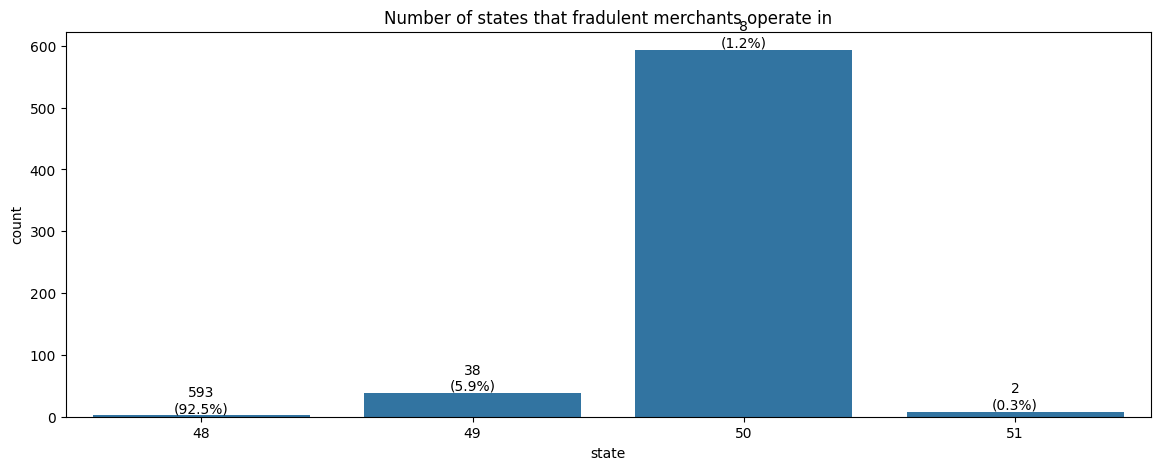

Most fradulent merchants operate in almost all states.


In [137]:
print(f"There are {len(df['merchant'].unique())} unique merchants. {len(fraud_merchant_periods)} of them have been involved in fraud.")

# Calculate number of states that fradulent merchants operates in
merchant_state = df1.loc[df1['merchant'].isin(fraud_merchant_periods.index)].groupby('merchant').nunique()['state'].reset_index()
# Tally state count
state_count = merchant_state['state'].value_counts().reset_index()

# Plot the bar plot
fig, ax = plt.subplots(figsize = (14,5))
sns.barplot(data = state_count, x = 'state', y = 'count', ax = ax)

total_merchants = state_count['count'].sum()
for i, p in enumerate(ax.patches):
    count = state_count.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    ax.annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    
ax.set_title('Number of states that fradulent merchants operate in')
plt.show()

# Print analysis
print('Most fradulent merchants operate in almost all states.')

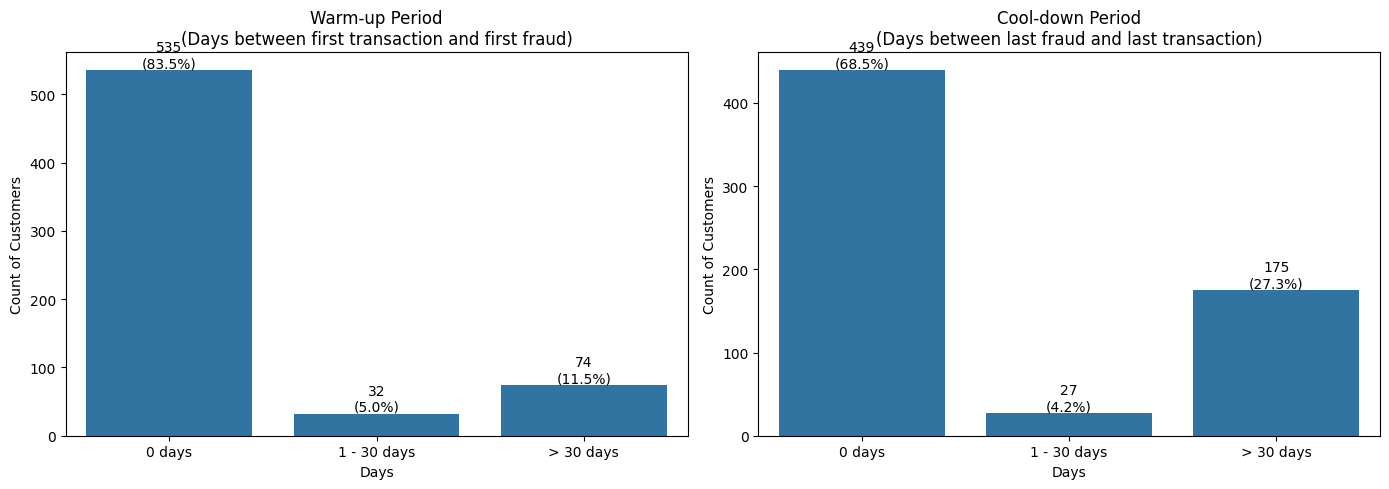

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days    535
1       1 - 30 days     32
2         > 30 days     74

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days    439
1         1 - 30 days     27
2           > 30 days    175

Percentage of merchants whose first transaction was fraudulent:
83.5% (535 merchants)

Percentage of merchants whose last transaction was fraudulent:
68.5% (439 merchants)


In [138]:

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts_merchant = fraud_merchant_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts_merchant.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts_merchant, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_merchants = warmup_counts_merchant['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts_merchant = fraud_merchant_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts_merchant.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts_merchant, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_merchants = cooldown_counts_merchant['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts_merchant)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts_merchant)

# Additional insights
print("\nPercentage of merchants whose first transaction was fraudulent:")
merchant_first_fraud_pct = (fraud_merchant_periods['warmup_days'] == 0).mean() * 100
print(f"{merchant_first_fraud_pct:.1f}% ({(fraud_merchant_periods['warmup_days'] == 0).sum()} merchants)")

print("\nPercentage of merchants whose last transaction was fraudulent:")
merchant_last_fraud_pct = (fraud_merchant_periods['cooldown_days'] == 0).mean() * 100
print(f"{merchant_last_fraud_pct:.1f}% ({(fraud_merchant_periods['cooldown_days'] == 0).sum()} merchants)")

It appears that fraudulent merchants are likely to immediately get involved in fraud and also stop transacting after the last fraud transaction.

This could lead to a hypothesis that some of these merchant accounts were created by fraudsters solely for the purpose of pulling off these frauds.

### Fraudulent transactions by location

In [139]:
# Proportion of fraudulent transactions by state
fraud_prop_by_state = df1.groupby('state')['is_fraud'].mean().reset_index(name = 'fraud_prop')
# Apply log transformation to normalize data for easy visualization
fraud_prop_by_state['log_prop'] = np.log(fraud_prop_by_state['fraud_prop'])/np.log(0.0001)

# Plot interactive map
fig = px.choropleth(fraud_prop_by_state, 
                     locations="state", 
                     locationmode="USA-states", 
                     color="log_prop", 
                     scope="usa",
                     color_continuous_scale="Viridis")
fig.show()


**Higher population leads to higher number of fraud cases**

May be because it is easier to commit fraud in a large city.

From the data, it shows that cities with a larger population leads to greater number of frauds from the best fit line.

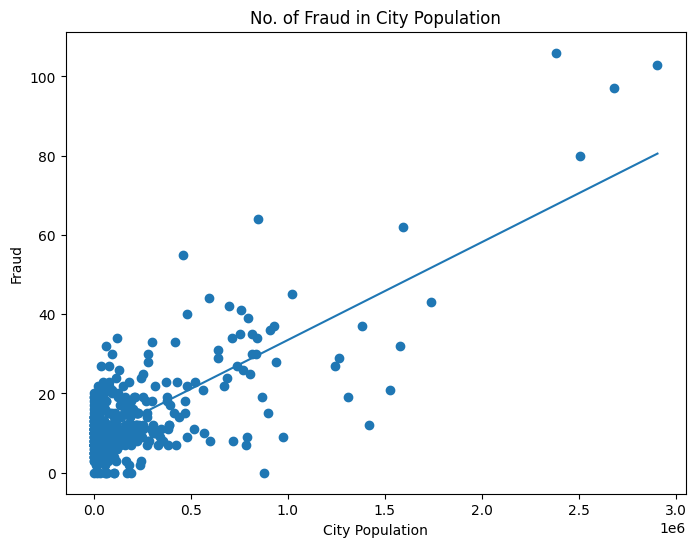

In [140]:
# Fraud count per city_pop. 
# Check if higher population leads to higher fraud cases
fraud_count = df1.groupby('city_pop')['is_fraud'].sum().reset_index()

a, b = np.polyfit(fraud_count["city_pop"], fraud_count["is_fraud"], 1)

plt.figure(figsize=(8, 6))
plt.scatter('city_pop','is_fraud', data=fraud_count)
plt.plot(fraud_count["city_pop"], a * fraud_count["city_pop"] + b)
plt.title('No. of Fraud in City Population')
plt.xlabel('City Population')
plt.ylabel('Fraud')
plt.show()

**Some cities are more popular for committing fraud**

Top 5 States by Fraud Percentage:
state  fraud_percentage  fraud_count  total_transactions
   DC        100.000000            8                   8
   ME          0.786925           26                3304
   NH          0.761277           67                8801
   RI          0.500911           22                4392
   PA          0.494890          353               71329

Bottom 5 States by Fraud Percentage:
state  fraud_percentage  fraud_count  total_transactions
   MT          0.174881           44               25160
   NV          0.178594           43               24077
   WY          0.190331           25               13135
   ND          0.221773           34               15331
   WV          0.231467           38               16417

Top 3 States with Highest Fraud Variability:
state  fraud_std  fraud_percentage  fraud_count
   ME   0.088359          0.786925           26
   NH   0.086918          0.761277           67
   RI   0.070598          0.500911           22

Botto

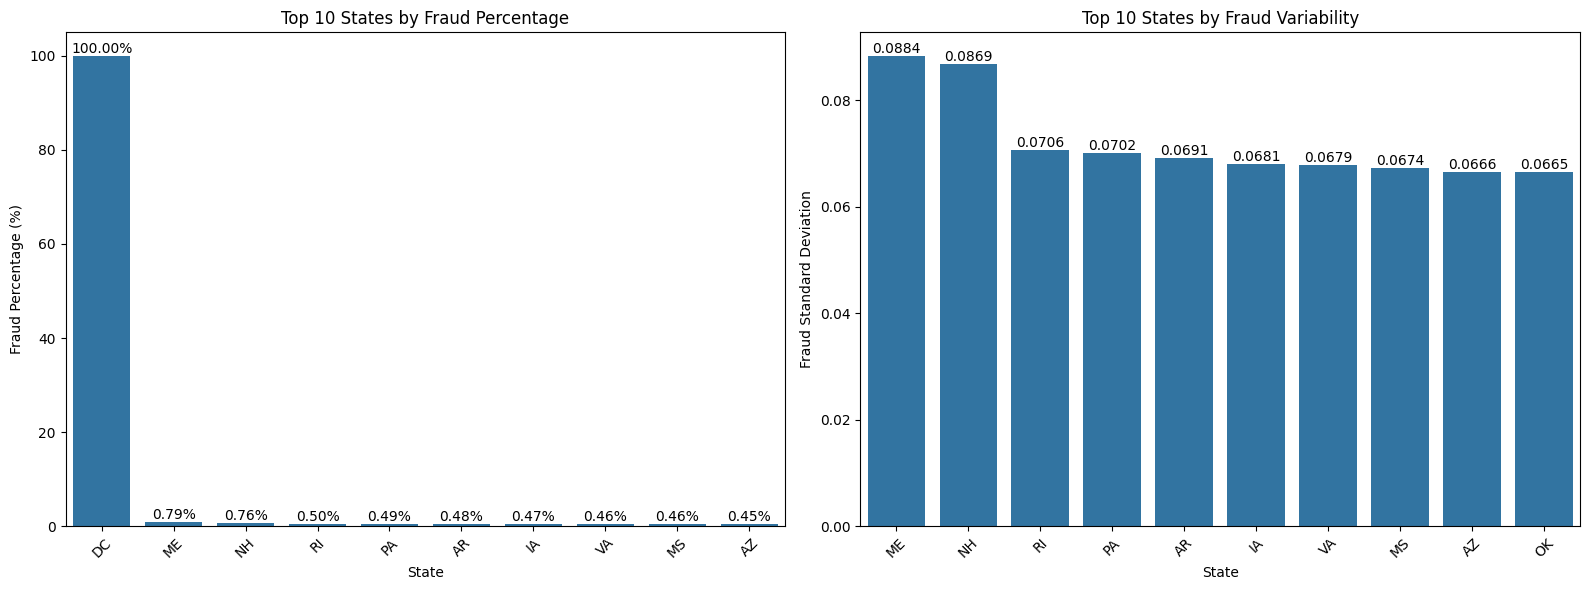

In [ ]:
def analyze_fraud_variability(df1):
    # Group by state and calculate fraud metrics
    fraud_by_state = df1.groupby('state').agg({
        'is_fraud': [
            ('fraud_count', lambda x: (x == 1).sum()),
            ('total_transactions', 'count'),
            ('fraud_std', lambda x: np.std(x))  # Calculate fraud sd
        ],
        'amt': [
            ('total_amount', 'sum'),
            ('fraud_amount', lambda x: x[df1['is_fraud'] == 1].sum()),
            ('fraud_amount_std', lambda x: np.std(x[df1['is_fraud'] == 1]))
        ]
    }).reset_index()
    
    # Flatten column names
    fraud_by_state.columns = [
        'state', 'fraud_count', 'total_transactions', 
        'fraud_std', 'total_amount', 'total_fraud_amount', 'fraud_amount_std'
    ]
    
    # Calculate fraud percentage
    fraud_by_state['fraud_percentage'] = (fraud_by_state['fraud_count'] / fraud_by_state['total_transactions']) * 100
    
    # Sort states by different metrics
    top_fraud_percentage = fraud_by_state.nlargest(5, 'fraud_percentage')
    bottom_fraud_percentage = fraud_by_state.nsmallest(5, 'fraud_percentage')
    
    # Top and bottom states by fraud standard deviation
    top_fraud_std = fraud_by_state.nlargest(3, 'fraud_std')
    bottom_fraud_std = fraud_by_state.nsmallest(3, 'fraud_std')

    plt.figure(figsize=(16, 6))
    
    # Fraud Percentage Plot
    plt.subplot(1, 2, 1)
    top_10_fraud = fraud_by_state.nlargest(10, 'fraud_percentage')
    ax1 = sns.barplot(x='state', y='fraud_percentage', data=top_10_fraud)
    plt.title('Top 10 States by Fraud Percentage')
    plt.xlabel('State')
    plt.ylabel('Fraud Percentage (%)')
    plt.xticks(rotation=45)
    # Add value labels 
    for i, bar in enumerate(ax1.patches):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%', 
                 ha='center', va='bottom')
    
    # Fraud Standard Deviation Plot
    plt.subplot(1, 2, 2)
    top_10_std = fraud_by_state.nlargest(10, 'fraud_std')
    ax2 = sns.barplot(x='state', y='fraud_std', data=top_10_std)
    plt.title('Top 10 States by Fraud Variability')
    plt.xlabel('State')
    plt.ylabel('Fraud Standard Deviation')
    plt.xticks(rotation=45)
    # Add value labels 
    for i, bar in enumerate(ax2.patches):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    print("Top 5 States by Fraud Percentage:")
    print(top_fraud_percentage[['state', 'fraud_percentage', 'fraud_count', 'total_transactions']].to_string(index=False))
    
    print("\nBottom 5 States by Fraud Percentage:")
    print(bottom_fraud_percentage[['state', 'fraud_percentage', 'fraud_count', 'total_transactions']].to_string(index=False))
    
    print("\nTop 3 States with Highest Fraud Variability:")
    print(top_fraud_std[['state', 'fraud_std', 'fraud_percentage', 'fraud_count']].to_string(index=False))
    
    print("\nBottom 3 States with Lowest Fraud Variability:")
    print(bottom_fraud_std[['state', 'fraud_std', 'fraud_percentage', 'fraud_count']].to_string(index=False))
    
    return fraud_by_state, plt

fraud_data , plot = analyze_fraud_variability(df1)
plot.show()

In [142]:
# City-level analysis across states
fraud_count_by_city = fraud_filter(['state', 'city'])
fraud_summary(fraud_count_by_city, 'city')

# Show highest fraud cities
print("\nCities with highest fraud counts:")
highest_fraud_loc = fraud_count_by_city[fraud_count_by_city['fraud_count'] > 12].sort_values(by='fraud_count', ascending=False)
print(highest_fraud_loc.head(10))

Average fraud per city: 12.094993581514762
Median fraud per city: 10.0
Standard deviation fraud per city: 9.152044075009778

Cities with highest fraud counts:
    state             city  fraud_count
70     CA      Los Angeles          106
680    TX          Houston          103
229    IL          Chicago           97
481    NY         Brooklyn           80
156    FL     Jacksonville           64
701    TX      San Antonio           62
183    FL  West Palm Beach           55
368    MN      Minneapolis           45
714    UT   Salt Lake City           44
163    FL            Miami           43


### Fraudulent transactions by category

In [143]:
# Fraud count and percentage per category
fraud_counts = df1[df1['is_fraud'] == 1]['category'].value_counts()
total_counts = df1['category'].value_counts()
fraud_percentage = (fraud_counts / total_counts * 100).fillna(0)

# As dataframe
fraud_by_cat = pd.DataFrame({'Fraud Cases': fraud_counts, 'Fraud Percentage': fraud_percentage})
fraud_by_cat = fraud_by_cat.sort_values(by='Fraud Cases', ascending=False)

print("Fraud cases and percentage by category:")
print(fraud_by_cat)

Fraud cases and percentage by category:
                Fraud Cases  Fraud Percentage
category                                     
shopping_net           2251          1.154531
grocery_pos            2205          0.892550
misc_net               1201          0.993852
shopping_pos           1097          0.421529
gas_transport           703          0.306866
entertainment           302          0.156057
misc_pos                290          0.166678
personal_care           261          0.139757
kids_pets               236          0.102737
home                    212          0.085584
food_dining             209          0.104848
health_fitness          163          0.098728
grocery_net             157          0.137750
travel                  135          0.159936


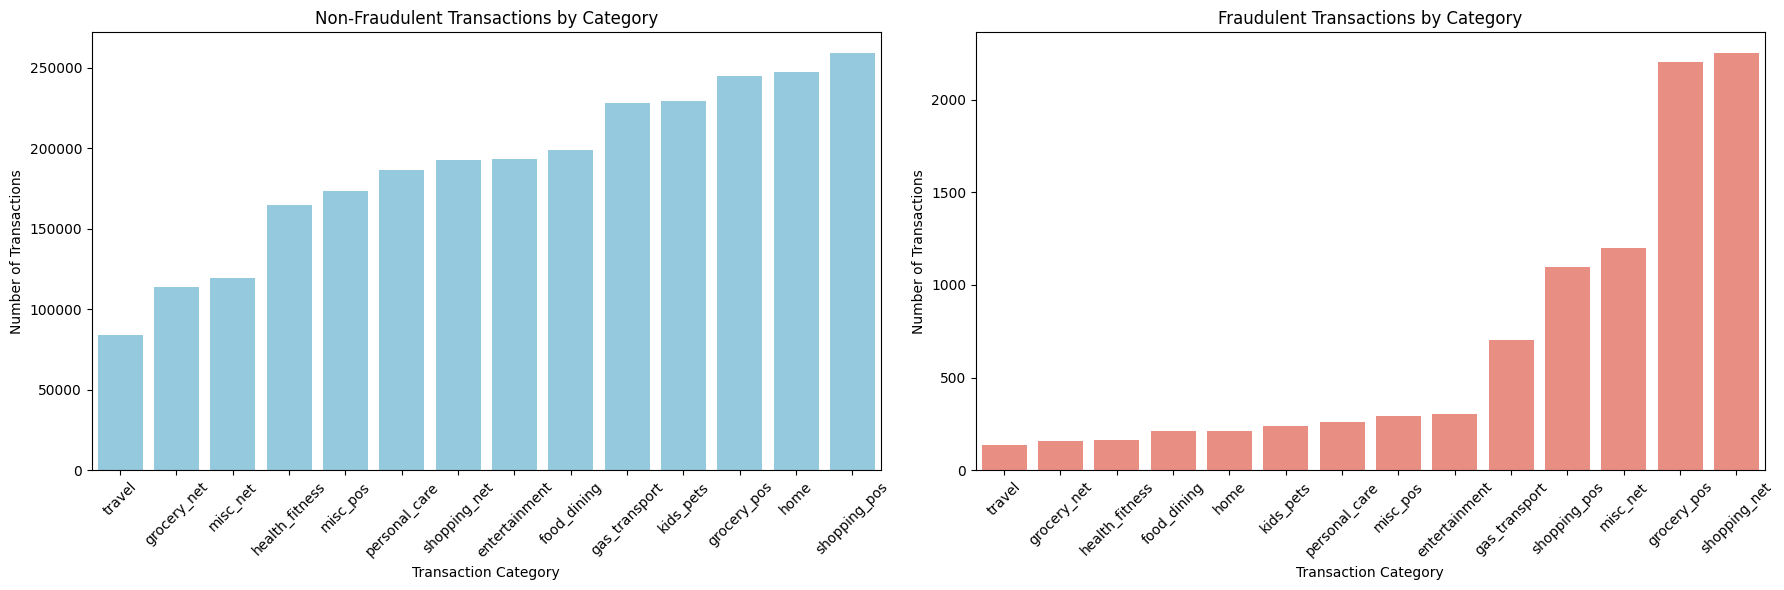

In [144]:
category_fraud = df1.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Non-Fraudulent Transactions by category
non_fraud = category_fraud.sort_values(by=0)
sns.barplot(x=non_fraud.index, y=non_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Category')
axes[0].set_xlabel('Transaction Category')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Plot Fraudulent Transactions by category
fraud = category_fraud.sort_values(by=1)
sns.barplot(x=fraud.index, y=fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Category')
axes[1].set_xlabel('Transaction Category')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Proportion of fraudulent transactions by age group

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\3892715962.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



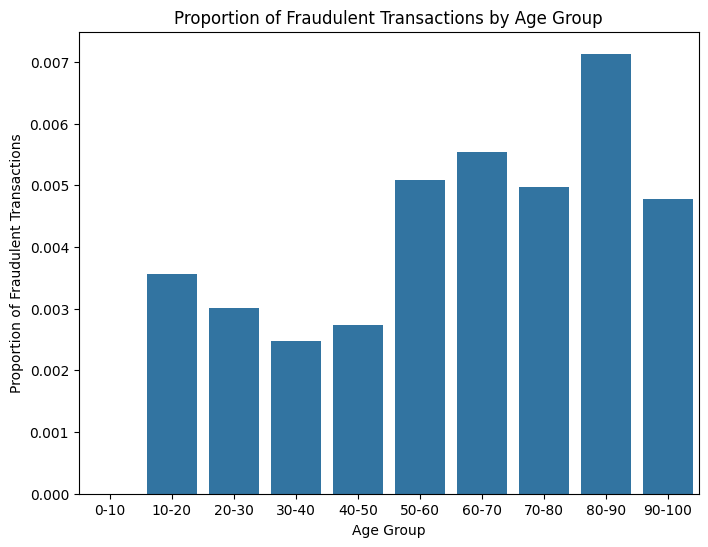

In [145]:
# Per age group analysis
age_fraud = df1.groupby('age_group')['is_fraud'].mean().reset_index()
age_fraud['is_fraud'] = age_fraud['is_fraud'].fillna(0)

# Plot Prportion of Fraudulent Transactions by age
plt.figure(figsize = (8, 6))
sns.barplot(data = age_fraud, x = 'age_group', y = 'is_fraud')
plt.title('Proportion of Fraudulent Transactions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.show()

### Fraudulent transaction by occupation

**Some occupations are prone to greater risk of fraudulent transactions than others**

Occupations that have a tendency to have strong earning power shows greater proportion of transactions being fraudulent, showing a tendency for fraudsters to target individuals with wealth

                                       job  is_fraud  total_count  \
29                     Art gallery manager        10           10   
358  Senior tax professional/tax inspector         8            8   
71                 Chief Marketing Officer        10           10   
334                        Records manager         7            7   
60                       Ceramics designer         9            9   

     fraud_percentage  
29              100.0  
358             100.0  
71              100.0  
334             100.0  
60              100.0  


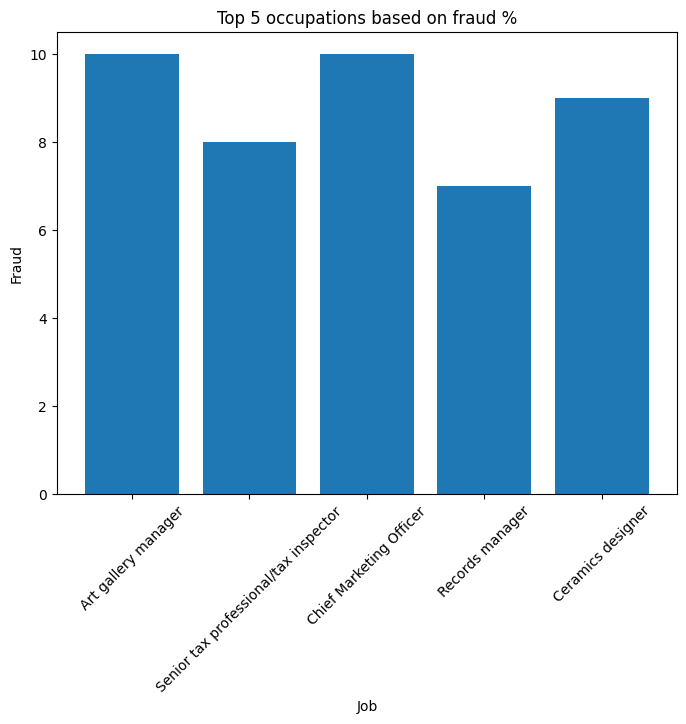

In [146]:
# x: city_state, y: fraud_count
# fraud count per city_pop, filter to a state to check
fraud_count = df1.groupby('job')['is_fraud'].sum().reset_index()

# Calculate total transactions by job
total_count = df1.groupby('job')['is_fraud'].count().reset_index()
total_count.rename(columns={'is_fraud': 'total_count'}, inplace=True)

# Merge fraud count and total count
fraud_percentage = pd.merge(fraud_count, total_count, on='job')

# Calculate percentage of fraud
fraud_percentage['fraud_percentage'] = (fraud_percentage['is_fraud'] / fraud_percentage['total_count']) * 100
top_5=fraud_percentage.sort_values(by='fraud_percentage',ascending=False).head(5)
print(top_5)
# show occupations with the highest % of frauds

plt.figure(figsize=(8, 6))
plt.bar('job','is_fraud', data=top_5) 
plt.title('Top 5 occupations based on fraud %')
plt.xlabel('Job')
plt.ylabel('Fraud')
plt.xticks(rotation=45)
plt.show()

### Fraudulent transactions by merchant


Merchants with highest fraud counts:
            merchant  fraud_count
472         Reichert          152
416         Mosciski           94
28          Baumbach           93
561          Streich           63
492        Romaguera           60
254             Huel           57
197        Greenholt           56
25   Bashirian Group           55
18      Bailey-Morar           55
316          Kovacek           55
Average fraud per merchant: 14.698907956318253
Median fraud per merchant: 7.0
Standard deviation fraud per merchant: 16.620424686155232


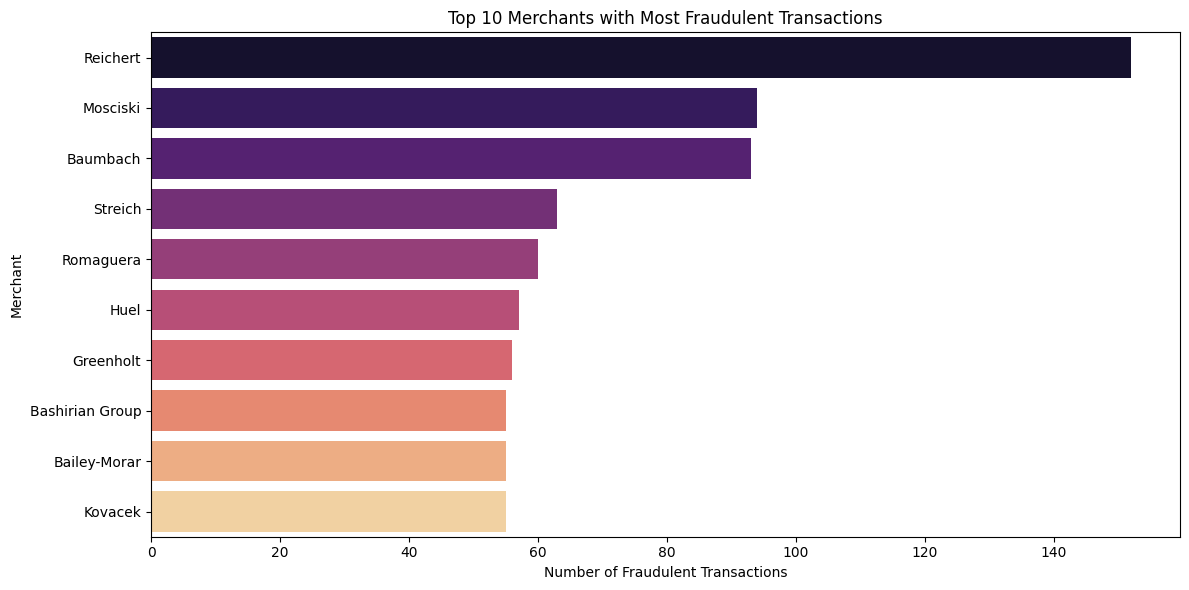


Analysis of top fraud merchants:
Merchant: Reichert
    Number of fraud transactions: 152
    Number of unique locations: 727
    Number of total customers: 11826
    Number of unique customers: 904
    Number of unique customers in fraud transactions: 140
    Average transaction amount: $75.36
    Most common transaction category: shopping_net
Merchant: Mosciski
    Number of fraud transactions: 94
    Number of unique locations: 726
    Number of total customers: 8780
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $78.40
    Most common transaction category: grocery_pos
Merchant: Baumbach
    Number of fraud transactions: 93
    Number of unique locations: 724
    Number of total customers: 14092
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $69.34
    Most common transaction category: shopping_pos


In [147]:
# Top merchants with fraudulent transactions
fraud_count_by_merchant = fraud_filter('merchant').sort_values(by='fraud_count', ascending=False)
print("Merchants with highest fraud counts:")
print(fraud_count_by_merchant.head(10))

# Calculate fraud summary stats for merchants
fraud_summary(fraud_count_by_merchant, 'merchant')

# Visualize top 10 merchants with most fraudulent transactions
top_fraud_merchants = fraud_count_by_merchant.nlargest(10, 'fraud_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_count', y='merchant', data=top_fraud_merchants, hue='merchant',palette='magma')
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

# Detailed analysis of top fraud merchants
print("\nAnalysis of top fraud merchants:")
fraud_merchants = list(fraud_count_by_merchant['merchant'].head(3))
for m in fraud_merchants:
    temp = df1[df1['merchant'] == m]
    print(f'Merchant: {m}')
    print(f'    Number of fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].count()}')
    print(f'    Number of unique locations: {temp["city_state"].nunique()}')
    print(f'    Number of total customers: {temp["ssn"].count()}')
    print(f'    Number of unique customers: {temp["ssn"].nunique()}')
    print(f'    Number of unique customers in fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].nunique()}')
    avg_transaction_amount = temp['amt'].mean()
    print(f'    Average transaction amount: ${avg_transaction_amount:.2f}')
    most_common_category = temp['category'].mode()[0]  # take the first value
    print(f'    Most common transaction category: {most_common_category}')

In [148]:
least_fraud_m = fraud_count_by_merchant.sort_values(by='fraud_count', ascending=True)
least_fraud_m.head(10)

,merchant,fraud_count
504,Runte,1
630,Wuckert-Walter,1
473,Reichert-Weissnat,1
540,Skiles-Ankunding,1
554,Stark-Koss,1
558,Stokes,1
371,Little-Gleichner,1
454,Pouros,1
33,Bednar Inc,1
508,Satterfield-Lowe,1


In [149]:
least_fraud_filter = least_fraud_m[least_fraud_m['fraud_count'] == 1]['merchant']

fraud_count_mc = fraud_filter(['merchant', 'ssn'])
fraud_count_mc = fraud_count_mc[fraud_count_mc['merchant'].isin(least_fraud_filter)]
fraud_count_mc.head()

,merchant,ssn,fraud_count
253,Bahringer-Streich,504142358,1
655,Bednar Inc,649608105,1
813,Bins-Howell,437446587,1
1034,Boyer-Haley,96658934,1
1670,Deckow-Dare,589058010,1


### Fraudulent transactions by customers

In [150]:
# No. of unique customers based on ssn numbers (check why full names vs ssn/cc_num is different)
unique_customers = df1['ssn'].nunique()
print(f"Number of unique customers based on ssn: {unique_customers}")

fraud_customers_ssn = df1[df1['is_fraud'] == 1]['ssn'].nunique()
total_customers_ssn = df1['ssn'].nunique()

print(f"\nNumber of unique customers who committed fraud (based on SSN): {fraud_customers_ssn}")
print(f"Percentage of customers who committed fraud (based on SSN): {(fraud_customers_ssn/total_customers_ssn)*100:.2f}%")


Number of unique customers based on ssn: 997

Number of unique customers who committed fraud (based on SSN): 985
Percentage of customers who committed fraud (based on SSN): 98.80%


In [151]:
# 1. Bar plot of top 5 customers with highest number of transactions
top_customers_by_trans_count = df1.groupby('ssn').size().sort_values(ascending=False).head(5)


# 3. Top 5 customers with highest proportion of fraudulent transactions
# Total transactions per customer
total_trans_per_customer = df1.groupby('ssn').size()

# No. of fraudulent transactions per customer
fraud_trans_per_customer = df1[df1['is_fraud'] == 1].groupby('ssn').size()

# Calculate proportion of fraudulent transactions
fraud_proportion = pd.DataFrame({
    'total_transactions': total_trans_per_customer,
    'fraud_transactions': fraud_trans_per_customer
}).fillna(0)

fraud_proportion['fraud_ratio'] = fraud_proportion['fraud_transactions'] / fraud_proportion['total_transactions']

# Get top 5 customers with highest fraud ratio (with at least 1 fraud transaction)
top_fraud_ratio = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].sort_values(
    'fraud_ratio', ascending=False).head(5)



In [152]:
# Print the actual numbers for reference
print("Top 5 customers with highest number of transactions:")
for ssn, count in zip(top_customers_by_trans_count.index, top_customers_by_trans_count.values):
    print(f"{ssn}: {count} transactions")

print("\nTop 5 customers with highest number of fraudulent transactions:")
for ssn, count in zip(fraud_counts.index, fraud_counts.values):
    print(f"{ssn}: {count} fraudulent transactions")

print("\nTop 5 customers with highest ratio of fraud:non-fraud transactions:")
for ssn, row in top_fraud_ratio.iterrows():
    print(f"{ssn}: {row['fraud_ratio']:.2%} ({int(row['fraud_transactions'])}/{int(row['total_transactions'])})")

Top 5 customers with highest number of transactions:
600568057: 6578 transactions
749692411: 6575 transactions
449246222: 6574 transactions
711832839: 6573 transactions
693836306: 6571 transactions

Top 5 customers with highest number of fraudulent transactions:
shopping_net: 2251 fraudulent transactions
grocery_pos: 2205 fraudulent transactions
misc_net: 1201 fraudulent transactions
shopping_pos: 1097 fraudulent transactions
gas_transport: 703 fraudulent transactions
entertainment: 302 fraudulent transactions
misc_pos: 290 fraudulent transactions
personal_care: 261 fraudulent transactions
kids_pets: 236 fraudulent transactions
home: 212 fraudulent transactions
food_dining: 209 fraudulent transactions
health_fitness: 163 fraudulent transactions
grocery_net: 157 fraudulent transactions
travel: 135 fraudulent transactions

Top 5 customers with highest ratio of fraud:non-fraud transactions:
21222723: 100.00% (8/8)
41324784: 100.00% (11/11)
518033701: 100.00% (9/9)
25417983: 100.00% (11/11

Since a high number of customers solely have fraudulent pruchases, we further explored the spread of this ratio of fraud:non-fraud 

In [153]:
# Fraud:non-fraud ratio distribution across customers who had at least 1 fraudulent transaction

# Filter customers
customers_with_fraud = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].copy()

# Create bins for fraud ratio
# Bin 1: 100% (all transactions are fraud)
# Bin 2: >50% and <100% (majority but not all are fraud)
# Bin 3: ≤50% (half or less are fraud)
bins = [0, 0.5, 0.99999, 1]
labels = ["≤50%", ">50% & <100%", "100%"]

# Categorize customers into bins
customers_with_fraud['fraud_bin'] = pd.cut(
    customers_with_fraud['fraud_ratio'], 
    bins=bins, 
    labels=labels, 
    right=True,
    include_lowest=True
)

# Count customers in each bin
bin_counts = customers_with_fraud['fraud_bin'].value_counts().sort_index()


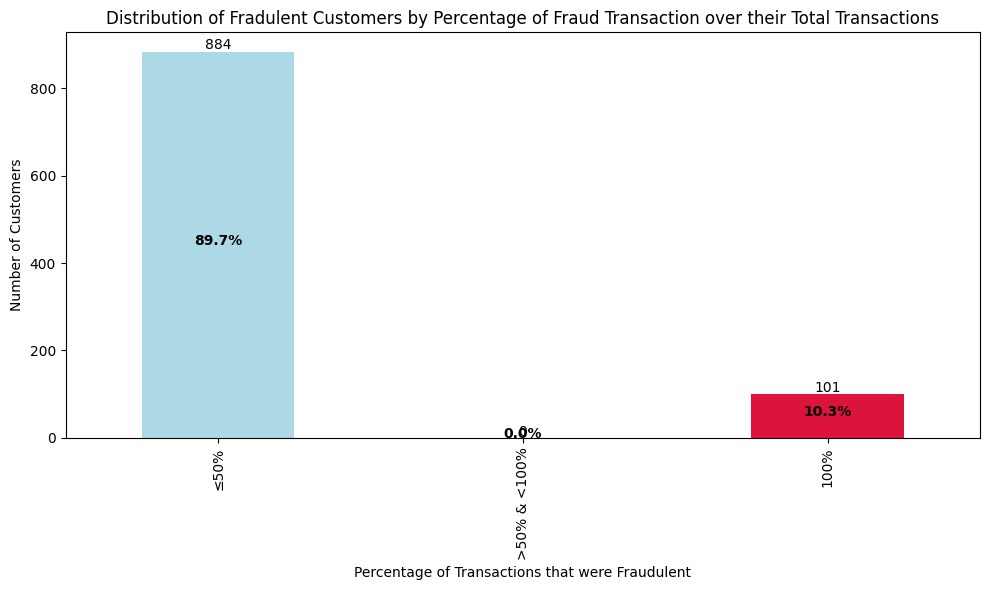

Total customers with at least one fraudulent transaction: 985
Customers with ≤50% fraudulent transactions: 884 (89.7%)
Customers with >50% & <100% fraudulent transactions: 0 (0.0%)
Customers with 100% fraudulent transactions: 101 (10.3%)


In [154]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = bin_counts.plot(kind='bar', color=['lightblue', 'orange', 'crimson'])
plt.title('Distribution of Fradulent Customers by Percentage of Fraud Transaction over their Total Transactions')
plt.xlabel('Percentage of Transactions that were Fraudulent')
plt.ylabel('Number of Customers')

# Add count labels on top of each bar
for i, count in enumerate(bin_counts):
    plt.text(i, count + 5, str(count), ha='center')

# Add a percentage label inside each bar
total_customers = bin_counts.sum()
for i, count in enumerate(bin_counts):
    percentage = (count / total_customers) * 100
    plt.text(i, count/2, f"{percentage:.1f}%", ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total customers with at least one fraudulent transaction: {total_customers}")
for label, count in bin_counts.items():
    print(f"Customers with {label} fraudulent transactions: {count} ({count/total_customers*100:.1f}%)")

In [155]:
# Finding their first transaction 
customer_first_trans = df.sort_values(['ssn', 'trans_date', 'trans_time']).groupby('ssn').head(1)

# Count of fraudulent first transactions 
fraud_first_trans_count = customer_first_trans['is_fraud'].sum()

print(f"Number of customers whose first transaction was fraudulent: {fraud_first_trans_count}")
print(f"Percentage of customers whose first transaction was fraudulent: {(fraud_first_trans_count/total_customers_ssn) *100}")

Number of customers whose first transaction was fraudulent: 102
Percentage of customers whose first transaction was fraudulent: 10.230692076228685


In [156]:
fraud_count_mc.groupby('ssn')['ssn'].count() 

ssn
59318309     1
69452671     1
96658934     1
136674961    1
162088321    1
193015279    1
206427252    1
242807389    1
297220579    1
437446587    1
452579812    1
504142358    1
546989371    1
552207135    1
581884763    1
589058010    1
601895938    1
603456914    1
627469417    1
649608105    1
755111150    1
766623506    1
808050763    1
832275040    1
855200599    1
860084836    1
877448505    1
Name: ssn, dtype: int64

In [157]:
fraud_count_by_consumers = fraud_filter('ssn').sort_values(by='fraud_count', ascending=False)
fraud_count_by_consumers.head(10)

,ssn,fraud_count
719,648073243,19
744,672906422,18
454,428323432,17
452,422559671,16
485,461607650,16
42,38714270,16
341,311934315,16
268,236758053,16
846,766623506,16
581,535663820,16


In [158]:
least_fraud_c = fraud_count_by_consumers.sort_values(by='fraud_count', ascending=True)
least_fraud_c.head(10)

,ssn,fraud_count
654,590868736,2
638,581080162,2
637,580380878,2
215,182220390,2
548,505026947,2
567,525567036,2
490,465986615,2
151,125638352,2
553,507888724,2
703,630564499,3


### Fraudulent transactions by value

**Fraud involves larger sums**

Transaction between $500 to $1000 shows the highest proportion of fraudulent transaction and as such it could be used to create a new feature using transaction amount bins

In [159]:
labels = ['0-100', '100-500', '500-1000', '1000-5000', '>5000']
bins = [0, 100, 500, 1000, 5000, float('inf')]



# Create a new column with the range
df1['amt_range'] = pd.cut(df1['amt'], bins=bins, labels=labels, right=False)
df1.groupby('amt_range')['is_fraud'].mean()

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\1946261618.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



amt_range
0-100        0.000893
100-500      0.006419
500-1000     0.159376
1000-5000    0.149479
>5000        0.000000
Name: is_fraud, dtype: float64

# Feature Engineering 

In [6]:
df2 = df.copy()

In [7]:
# Apply data cleaning (similar to EDA)

# Convert date and time to appropriate data types
df2[['trans_date','dob']] = df2[['trans_date','dob']].apply(pd.to_datetime)
df2['trans_time'] = pd.to_datetime(df2['trans_time'], format='%H:%M:%S')

# Extract transaction time features
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df2['hour'] = df2['trans_time'].dt.hour
df2['day_of_week'] = pd.Categorical(df2['trans_date'].dt.day_name(), categories=week_order, ordered=True)
df2['month'] = df2['trans_date'].dt.to_period('M').dt.to_timestamp()
df2["trans_quarter"] = pd.PeriodIndex(df2['month'], freq='Q')
df2['year'] = df2['trans_date'].dt.year

# Calculate age at the time of the transaction
def calc_age(data):
    est = data['year'] - data['dob'].year
    if (data['trans_date'].month < data['dob'].month) or ((data['trans_date'].month == data['dob'].month) and (data['trans_date'].day < data['dob'].day)):
        return est - 1
    else:
        return est
    
df2['age'] = df2.apply(lambda x: calc_age(x), axis = 1)

# Merge `city` and `state` columns
df2['city_state'] = df2['city'] + ', ' + df2['state']

# Clean `merchant` feature
df2['merchant'] = df2['merchant'].str.replace('fraud_','',regex=False)

* category_percentage_deviation = amount spent percentage deviation by category- to detect if any amount is above the usual non-fraudulent average for that category. 
* running count of fraud (for customer) - prev_trans_fraud, count_fraud_prev10, accumulative_fraud 
* running count of fraud (for merchant) - prev_trans_fraud, count_fraud_prev10, accumulative_fraud 
* holidays season's risk 
* indicator for whether category was visited in previous 100 transactions
* interval between current transaction and previous transaction (in seconds)
* current interval / median interval of past 75 transactions (or fewer if no data)
* current amount / mean transaction amount of past 75 transactions (or fewer if no data)



In [8]:
def category_avg_feature(df):
    category_avg = df[df['is_fraud'] == 0].groupby('category')['amt'].mean()
    
    # Store in dictionary for efficient lookup
    category_avg_dict = category_avg.to_dict()
    
    def calculate_deviation(row):
        cat_avg = category_avg_dict.get(row['category'], 0)
        percent_dev = ((row['amt'] - cat_avg) / cat_avg) * 100 if cat_avg != 0 else 0
        return percent_dev
    
    # Apply the deviation calculations
    df['category_percentage_deviation'] = df.apply(calculate_deviation, axis=1)
    
    return df

df2 = category_avg_feature(df2)

In [9]:
# for customers - prev_trans_fraud, count_fraud_prev10, accumulative_fraud

# Sorting data by transaction date and time (add to cleaning above?)
df2['trans_datetime'] = pd.to_datetime(df2['trans_date'].dt.date.astype(str) + ' ' + df2['trans_time'].dt.time.astype(str))
df2 = df2.sort_values(['ssn', 'trans_datetime'])


# To check if the customer's previous transaction was fraud
df2['prev_trans_fraud'] = 0

# Group by ssn and process each customer's transactions
for ssn, group in df2.groupby('ssn'):
    prev_fraud = group['is_fraud'].shift(1) # Use shift function in pandas to get their previous transasction 
    prev_fraud = prev_fraud.fillna(0)
    df2.loc[group.index, 'prev_trans_fraud'] = prev_fraud.astype(int)



# Fraud in the past 10 transactions
df2['count_fraud_prev10'] = 0

# Dictionary to store recent transactions by ssn
ssn_recent_frauds = {}


for idx, row in df2.iterrows(): #use idx so we can use iterrows later
    ssn = row['ssn']
    is_fraud = row['is_fraud']
    
    if ssn not in ssn_recent_frauds:
        ssn_recent_frauds[ssn] = []
    
    fraud_count = sum(ssn_recent_frauds[ssn])
    df2.at[idx, 'count_fraud_prev10'] = fraud_count
    ssn_recent_frauds[ssn].append(is_fraud)
    
    if len(ssn_recent_frauds[ssn]) > 10:
        ssn_recent_frauds[ssn].pop(0)  # Remove oldest, keep only the 10 most recent transactions


# accumualtive fraud count
df2['acc_fraud_count'] = df2.groupby('ssn')['is_fraud'].transform(
    lambda x: x.cumsum().shift(1).fillna(0).astype(int) #shift by 1 to exclude current transaction
) 


In [164]:
# for merchants - prev_trans_fraud, count_fraud_prev10, accumulative_fraud

df2['trans_datetime'] = pd.to_datetime(df2['trans_date'].dt.date.astype(str) + ' ' + df2['trans_time'].dt.time.astype(str))
df2 = df2.sort_values(['merchant', 'trans_datetime'])


# merchant_prev_trans_fraud
df2['merchant_prev_trans_fraud'] = 0


for merchant, group in df2.groupby('merchant'):
    prev_fraud = group['is_fraud'].shift(1)
    prev_fraud = prev_fraud.fillna(0)
    df2.loc[group.index, 'merchant_prev_trans_fraud'] = prev_fraud.astype(int)



# merchant_count_fraud_prev10
df2['merchant_count_fraud_prev10'] = 0

# Dictionary to store recent transactions by merchant
merchant_recent_frauds = {}

for idx, row in df2.iterrows():
    merchant = row['merchant']
    is_fraud = row['is_fraud']
    
    if merchant not in merchant_recent_frauds:
        merchant_recent_frauds[merchant] = []
    
    fraud_count = sum(merchant_recent_frauds[merchant])
    df2.at[idx, 'merchant_count_fraud_prev10'] = fraud_count
    merchant_recent_frauds[merchant].append(is_fraud)
    
    if len(merchant_recent_frauds[merchant]) > 10:
        merchant_recent_frauds[merchant].pop(0)  # Remove oldest, keep only the 10 most recent transactions



# Merchant accumulative fraud 

df2['merchant_acc_fraud_count'] = df2.groupby('merchant')['is_fraud'].transform(
    lambda x: x.cumsum().shift(1).fillna(0).astype(int) #shift by 1 to exclude current trans
)

In [165]:
# peak spending period's risk 
def calculate_risk_score(df):
    """
    Risk Scoring Criteria:
    - High Risk (2): Nov 1st - Jan 7th (holiday period)
    - Medium Risk (1): 
      * June - August
      * Two weeks before November (Oct 18th - Oct 31st)
      * One week after Jan 7th (Jan 8th - Jan 14th)
    - Low Risk (0): All other periods
    """
    def _risk_score(month, day):
        # High-risk period (Holiday season)
        if (month.month == 11 and day >= 1) or \
           (month.month == 12) or \
           (month.month == 1 and day <= 7):
            return 2
        
        # Medium-risk periods (Summer months, June - August)
        if month.month in [6, 7, 8]:
            return 1
        
        # Two weeks before November (Oct 18 - Oct 31)
        if month.month == 10 and 18 <= day <= 31:
            return 1
        
        # One week after Jan 7th (Jan 8 - Jan 14)
        if month.month == 1 and 8 <= day <= 14:
            return 1
        
        return 0

    return df.apply(lambda row: _risk_score(row['month'], row['trans_date'].day), axis=1)

df2['transaction_risk_score'] = calculate_risk_score(df2)

In [166]:
def trans_interval(df, w):
    # Find the interval between transactions
    freq_purchases = df.sort_values(['ssn', 'unix_time'])[['ssn', 'trans_num', 'unix_time', 'trans_quarter']]
    freq_purchases['prev_unix_time'] = freq_purchases.groupby('ssn').shift(1)['unix_time']
    freq_purchases['interval'] = freq_purchases['unix_time'] - freq_purchases['prev_unix_time']
    freq_purchases['prev_interval'] = freq_purchases.groupby('ssn').shift(1)['interval']
    freq_purchases = freq_purchases.sort_values(['ssn', 'unix_time'])

    # Find the median interval for each quarter (median to cancel out effects of any fraud transactions)
    def rolling_interval(series, window):
        queue = deque(maxlen=window) 
        result = []
        sl = SortedList()

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    sl.remove(removed)
                    
                queue.append(val)
                sl.add(val)
                
            if len(sl) % 2 == 1:
                result.append(sl[len(sl) // 2])
            elif len(sl) == 0:
                result.append(np.nan)
            else:
                result.append(sl[len(sl) // 2 - 1] + sl[len(sl) // 2] / 2)

        return result
    
    freq_purchases['rolling_median_interval']= freq_purchases.groupby('ssn')['prev_interval'].transform(lambda x: rolling_interval(x, w))

    # Add 'interval' and 'prev_median_interval' columns to main df
    df = pd.merge(df, freq_purchases[['trans_num', 'interval', 'rolling_median_interval']], how = 'left', on = 'trans_num')

    # Compare each transaction's interval to the user's median interval in previous quarter
    df['interval_median_ratio'] = round(df['interval']/df['rolling_median_interval'], 2)

    # Drop 'prev_median_interval' column
    df = df.drop(['rolling_median_interval'], axis = 1)

    return df

df2 = trans_interval(df2, 75)

In [13]:
def categories_visited(df, w):
    # Sort transactions chronologically for each customer
    df = df.sort_values(['ssn', 'unix_time'])

    # Shift categories for each customer
    df['prev_cat'] = df.groupby('ssn')['category'].shift(1)

    # Function to track unique categories visited in rolling window
    def rolling_unique(series, window):
        queue = deque(maxlen=window) 
        seen = set()
        result = []

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    if removed not in queue:  
                        seen.discard(removed)

                queue.append(val)
                seen.add(val)

        
            result.append({value: 1 for value in seen})

        return result
    
    # Find unique categories visited up to 100 transacitons ago
    df['rolling_prev_cat'] = df.groupby('ssn')['prev_cat'].transform(lambda x: rolling_unique(x, w))
    # Create indicator for whether current transaction category has been visited before
    df['visited_cat'] = [int(bool(d.get(c))) if isinstance(d, dict) else None for d, c in zip(df['rolling_prev_cat'], df['category'])]
    # Drop columns for previous categories and shifted categories
    df = df.drop(['rolling_prev_cat', 'prev_cat'], axis = 1)
    
    return df

df2 = categories_visited(df2, 75)

In [14]:
def mean_trans_amt(df, w):

    df = df.sort_values(['ssn', 'unix_time'])
    
    # Function to compute mean amount in rolling window
    def rolling_mean(series, window):
        queue = deque(maxlen=window) 
        result = []
        running_sum = 0

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    running_sum -= removed
                    
                queue.append(val)
                running_sum += val
                
            if len(queue) > 0:
                result.append(running_sum / len(queue)) 
            else:
                result.append(np.nan) 

        return result
    
    trans_amt = df[['ssn', 'category', 'trans_num', 'amt']]
    trans_amt['ssn_cat'] = trans_amt['ssn'].astype(str) + ' ' + trans_amt['category']
    trans_amt['prev_amt'] = trans_amt.groupby('ssn_cat').shift(1)['amt']
    trans_amt['cat_rolling_mean'] = trans_amt.groupby(['ssn_cat'])['prev_amt'].transform(lambda x: rolling_mean(x, w))

    # Add 'cat_rolling_mean' columns to main df
    df = pd.merge(df, trans_amt[['trans_num', 'cat_rolling_mean']], how = 'left', on = 'trans_num')

    # Compare each transaction's amount to the user's rolling mean transaction amount for that category
    df['amt_hist_ratio'] = round(df['amt']/df['cat_rolling_mean'], 2)

    # Drop 'cat_rolling_mean' column
    df = df.drop(['cat_rolling_mean'], axis = 1)

    return df

df2 = mean_trans_amt(df2, 75)

/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amt['ssn_cat'] = trans_amt['ssn'].astype(str) + ' ' + trans_amt['category']
/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amt['prev_amt'] = trans_amt.groupby('ssn_cat').shift(1)['amt']
/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:30: SettingWithCopyWarning: 
A

In [15]:
def city_population_size(df):

    city_population_bin = [0, 350000, 1000000, np.inf]
    labels = ["small", "medium", "large"]
    df.loc[:, "city_popluation_class"] = pd.cut(df.loc[:, "city_pop"], bins = city_population_bin, labels = labels)
    return df

df2 = city_population_size(df2)

In [16]:
def get_top_3_cities(df):

    city_ranking = df[["state", "city", "is_fraud"]].groupby(by = ["state", "city"], as_index = False).apply(lambda x: pd.Series({"city_fraud_proportion": x["is_fraud"].sum()/len(x)}))
    city_ranking.sort_values(by = ["state", "city_fraud_proportion"], inplace = True, ascending = False)
    top_3_cities = city_ranking.groupby(by = ["state"], as_index = False).head(3)

    df = df.merge(top_3_cities, how = "left", on = ["state", "city"])
    df["top_3_city"] = df["city_fraud_proportion"].apply(lambda x: 0 if x != x else 1)
    
    return df
# df_test["top_3_city"] = df_test["city_fraud_proportion"].apply(lambda x: 0 if x != x else 1)
df2 = mean_trans_amt(df2, 75)

/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amt['ssn_cat'] = trans_amt['ssn'].astype(str) + ' ' + trans_amt['category']
/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amt['prev_amt'] = trans_amt.groupby('ssn_cat').shift(1)['amt']
/var/folders/fl/982cw_1x42jd0883_dqg16_80000gn/T/ipykernel_49956/70047052.py:30: SettingWithCopyWarning: 
A

In [169]:
# Drop columns not used
cols_to_drop = ['trans_date', 'city', 'dob', 'trans_time', 'unix_time']

df2 = df2.drop(cols_to_drop, axis = 1)

In [12]:
def trans_interval(df, w):
    # Find the interval between transactions
    freq_purchases = df.sort_values(['ssn', 'unix_time'])[['ssn', 'trans_num', 'unix_time', 'trans_quarter']]
    freq_purchases['prev_unix_time'] = freq_purchases.groupby('ssn').shift(1)['unix_time']
    freq_purchases['interval'] = freq_purchases['unix_time'] - freq_purchases['prev_unix_time']
    freq_purchases['prev_interval'] = freq_purchases.groupby('ssn').shift(1)['interval']
    freq_purchases = freq_purchases.sort_values(['ssn', 'unix_time'])

    # Find the median interval for each quarter (median to cancel out effects of any fraud transactions)
    def rolling_interval(series, window):
        queue = deque(maxlen=window) 
        result = []
        sl = SortedList()

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    sl.remove(removed)
                    
                queue.append(val)
                sl.add(val)
                
            if len(sl) % 2 == 1:
                result.append(sl[len(sl) // 2])
            elif len(sl) == 0:
                result.append(np.nan)
            else:
                result.append(sl[len(sl) // 2 - 1] + sl[len(sl) // 2] / 2)

        return result
    
    freq_purchases['rolling_median_interval']= freq_purchases.groupby('ssn')['prev_interval'].transform(lambda x: rolling_interval(x, w))

    # Add 'interval' and 'prev_median_interval' columns to main df
    df = pd.merge(df, freq_purchases[['trans_num', 'interval', 'rolling_median_interval']], how = 'left', on = 'trans_num')

    # Compare each transaction's interval to the user's median interval in previous quarter
    df['interval_median_ratio'] = round(df['interval']/df['rolling_median_interval'], 2)

    # Drop 'prev_median_interval' column
    df = df.drop(['rolling_median_interval'], axis = 1)

    return df

df2 = trans_interval(df2, 75)

In [18]:
def categories_visited(df, w):
    # Sort transactions chronologically for each customer
    df = df.sort_values(['ssn', 'unix_time'])

    # Shift categories for each customer
    df['prev_cat'] = df.groupby('ssn')['category'].shift(1)

    # Function to track unique categories visited in rolling window
    def rolling_unique(series, window):
        queue = deque(maxlen=window) 
        seen = set()
        result = []

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    if removed not in queue:  
                        seen.discard(removed)

                queue.append(val)
                seen.add(val)

        
            result.append({value: 1 for value in seen})

        return result
    
    # Find unique categories visited up to 100 transacitons ago
    df['rolling_prev_cat'] = df.groupby('ssn')['prev_cat'].transform(lambda x: rolling_unique(x, w))
    # Create indicator for whether current transaction category has been visited before
    df['visited_cat'] = [int(bool(d.get(c))) if isinstance(d, dict) else None for d, c in zip(df['rolling_prev_cat'], df['category'])]
    # Drop columns for previous categories and shifted categories
    df = df.drop(['rolling_prev_cat', 'prev_cat'], axis = 1)
    
    return df

df2 = categories_visited(df2, 75)

In [168]:
def mean_trans_amt(df, w):

    df = df.sort_values(['ssn', 'unix_time'])
    
    # Function to compute mean amount in rolling window
    def rolling_mean(series, window):
        queue = deque(maxlen=window) 
        result = []
        running_sum = 0

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    running_sum -= removed
                    
                queue.append(val)
                running_sum += val
                
            if len(queue) > 0:
                result.append(running_sum / len(queue)) 
            else:
                result.append(np.nan) 

        return result
    
    trans_amt = df[['ssn', 'category', 'trans_num', 'amt']]
    trans_amt['ssn_cat'] = trans_amt['ssn'].astype(str) + ' ' + trans_amt['category']
    trans_amt['prev_amt'] = trans_amt.groupby('ssn_cat').shift(1)['amt']
    trans_amt['cat_rolling_mean'] = trans_amt.groupby(['ssn_cat'])['prev_amt'].transform(lambda x: rolling_mean(x, w))

    # Add 'cat_rolling_mean' columns to main df
    df = pd.merge(df, trans_amt[['trans_num', 'cat_rolling_mean']], how = 'left', on = 'trans_num')

    # Compare each transaction's amount to the user's rolling mean transaction amount for that category
    df['amt_hist_ratio'] = round(df['amt']/df['cat_rolling_mean'], 2)

    # Drop 'cat_rolling_mean' column
    df = df.drop(['cat_rolling_mean'], axis = 1)

    return df

df2 = mean_trans_amt(df2, 75)

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\70047052.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\70047052.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chloe\AppData\Local\Temp\ipykernel_40232\70047052.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [169]:
# Drop columns not used
cols_to_drop = ['trans_date', 'city', 'dob', 'trans_time', 'unix_time']

df2 = df2.drop(cols_to_drop, axis = 1)